----------------------------------------------------------------------
RESUMEN:
  Longitud total en X: 220.4 m
  Altura máxima: 100.0 m
  Altura mínima: 0.0 m
  Número total de puntos: 246
----------------------------------------------------------------------
B-SPLINE CREADO:
  Grado: 3
  Número de nodos: 250
  Dominio u: [0.0000, 1.0000]
  Suavizado: 0
----------------------------------------------------------------------
VERIFICACIÓN DE INTERPOLACIÓN:
  Error máximo en x: 1.42e-13 m
  Error máximo en z: 4.26e-14 m
  Interpolación exacta


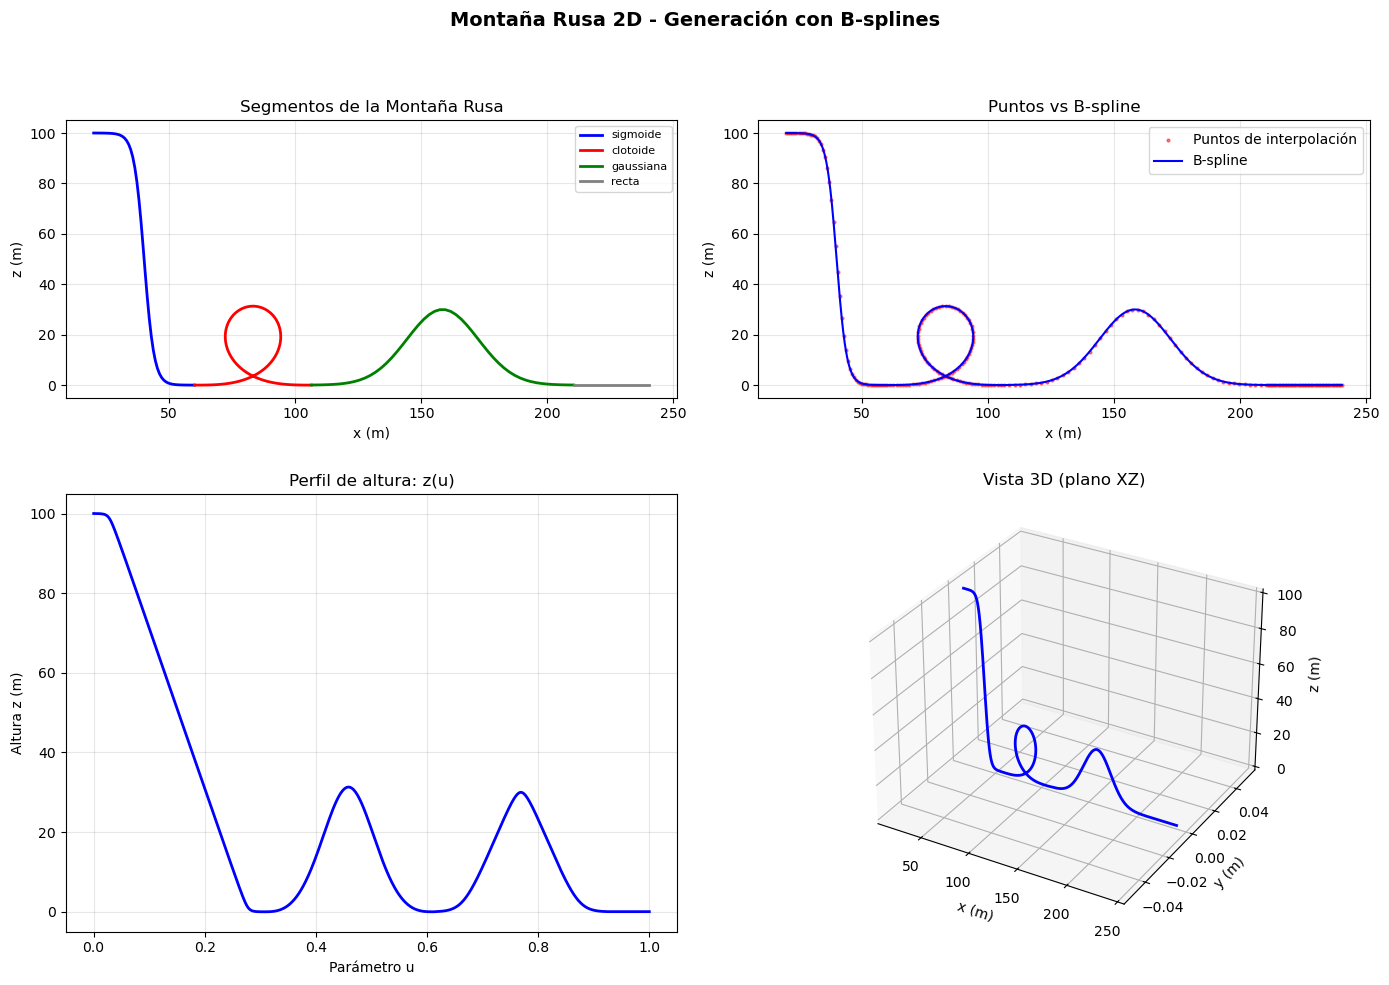

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import scipy.interpolate as scip
import scipy.integrate as scin

import pkgcurvas as curvas
import pkgmrusa as mrusa

class Segmento:
    """Clase base para segmentos de la montaña rusa"""
    def __init__(self, nombre, color='blue'):
        self.nombre = nombre
        self.color = color
        self.x = None
        self.z = None
    
    def generar(self, x0, z0, n_puntos=50):
        """Genera los puntos del segmento"""
        raise NotImplementedError
    
    def get_punto_final(self):
        """Retorna el punto final del segmento"""
        return self.x[-1], self.z[-1]

class Sigmoide(Segmento):
    """
    Descenso pronunciado usando función sigmoide: x(u) = x0 + u, y(u) = y0 + A/(1+exp(m*u))
    """
    def __init__(self, A=100, m=0.5, u_min=-20, u_max=20, color='blue'):
        super().__init__('sigmoide', color)
        self.A = A
        self.m = m
        self.u_min = u_min
        self.u_max = u_max
    
    def generar(self, x0, z0, n_puntos=50):
        u = np.linspace(self.u_min, self.u_max, n_puntos)
        
        # Usamos la función del paquete curvas
        x_sig, z_sig = curvas.sigmoide(u, A=self.A, s=self.m)
        
        self.x = x_sig + x0 - self.u_min
        self.z = z_sig + z0
        
        return self.x, self.z

class Clotoide(Segmento):
    """
    Bucle usando clotoide (espiral de Euler)
    """
    def __init__(self, A=35, u_max=None, color='red'):
        super().__init__('clotoide', color)
        self.A = A
        # u_max = sqrt(pi) para media clotoide, el loop completo es simétrico
        if u_max is not None:
            self.u_max = u_max 
        else:
            self.u_max = np.sqrt(np.pi)
    
    def generar(self, x0, z0, n_puntos=80):
        """
        Generamos media clotoide y se refleja para crear el loop completo
        """
        u = np.linspace(0, self.u_max, n_puntos)
        
        # Usamos la función del paquete curvas
        x_half, z_half = curvas.clotoide(u, A=self.A, p0=0)
        
        # La segunda mitad es el reflejo respecto al punto final
        x_full = np.concatenate([x_half, 2*x_half[-1] - x_half[::-1][1:]])
        z_full = np.concatenate([z_half, z_half[::-1][1:]])
        
        self.x = x_full + x0
        self.z = z_full + z0
        
        return self.x, self.z

class Gaussiana(Segmento):
    """
    Colina usando campana de Gauss: x(u) = x0 + u, y(u) = y0 + A*exp(-(u/s)**2)
    """
    def __init__(self, A=30, s=20, u_min=-52, u_max=52, color='green'):
        super().__init__('gaussiana', color)
        self.A = A
        self.s = s
        self.u_min = u_min
        self.u_max = u_max
    
    def generar(self, x0, z0, n_puntos=50):
        u = np.linspace(self.u_min, self.u_max, n_puntos)
        
        # Usar la función del paquete curvas
        x_gauss, z_gauss = curvas.gausiana(u, A=self.A, s=self.s)
        
        self.x = x_gauss - self.u_min + x0
        self.z = z_gauss + z0
        
        return self.x, self.z

class Recta(Segmento):
    """
    Tramo recto (horizontal o inclinado): x(u) = x0 + u, y(u) = y0 + m*u
    """
    def __init__(self, longitud=30, pendiente=0, color='gray'):
        super().__init__('recta', color)
        self.longitud = longitud
        self.pendiente = pendiente
    
    def generar(self, x0, z0, n_puntos=20):
        u = np.linspace(0, self.longitud, n_puntos)
        
        self.x = x0 + u
        self.z = z0 + self.pendiente * u
        
        return self.x, self.z

class MontañaRusa2D:
    """
    Construir una montaña rusa 2D a partir de segmentos modulares.
    """
    def __init__(self, nombre="Montaña Rusa 2D"):
        self.nombre = nombre
        self.segmentos = []
        self.x_total = None
        self.z_total = None
        self.bspline = None
        self.tck = None
        self.u_params = None
    
    def agregar_segmento(self, segmento):
        self.segmentos.append(segmento)
        return self
    
    def construir(self, x_inicio=0, z_inicio=0, n_puntos_por_segmento=50):       
        x_actual = x_inicio
        z_actual = z_inicio
        
        arrays_x = []
        arrays_z = []
        
        for i, seg in enumerate(self.segmentos):
            x, z = seg.generar(x_actual, z_actual, n_puntos_por_segmento)
            
            if i == 0:
                arrays_x.append(x)
                arrays_z.append(z)
            else:
                # Quito el primer punto (ya está en el anterior)
                arrays_x.append(x[1:])
                arrays_z.append(z[1:])
            
            x_actual, z_actual = seg.get_punto_final()
        
        self.x_total = np.concatenate(arrays_x)
        self.z_total = np.concatenate(arrays_z)
        
        print("-" * 70)
        print(f"RESUMEN:")
        print(f"  Longitud total en X: {self.x_total[-1] - self.x_total[0]:.1f} m")
        print(f"  Altura máxima: {self.z_total.max():.1f} m")
        print(f"  Altura mínima: {self.z_total.min():.1f} m")
        print(f"  Número total de puntos: {len(self.x_total)}")
        
        return self
    
    def crear_bspline(self, suavizado=0, grado=3):
        """
        Crea un B-spline paramétrico 3D (y=0 porque es 2D en el plano XZ)
        """
        if self.x_total is None:
            raise ValueError("Hay que construir primero la montaña rusa")
        
        # Y es todo ceros (plano XZ)
        y = np.zeros_like(self.x_total)
        
        # Creamos el array 3D de puntos
        puntos_3d = np.array([self.x_total, y, self.z_total])
        
        # Generamos B-spline
        self.tck, self.u_params = scip.splprep(puntos_3d, s=suavizado, k=grado)
        
        # Extraemos componentes y creamos objeto BSpline
        t, c, k = self.tck
        c_array = np.array(c).T
        self.bspline = scip.BSpline(t, c_array, k)
        
        print("-" * 70)
        print(f"B-SPLINE CREADO:")
        print(f"  Grado: {k}")
        print(f"  Número de nodos: {len(t)}")
        print(f"  Dominio u: [{self.u_params[0]:.4f}, {self.u_params[-1]:.4f}]")
        print(f"  Suavizado: {suavizado}")
        
        return self
    
    def verificar_interpolacion(self):
        """Verificar que el B-spline interpola correctamente los puntos."""
        if self.bspline is None:
            raise ValueError("Primero hay que crear el B-spline")
        
        pos = self.bspline(self.u_params)
        
        error_x = np.abs(pos[:, 0] - self.x_total)
        error_z = np.abs(pos[:, 2] - self.z_total)
        
        print("-"*70)
        print("VERIFICACIÓN DE INTERPOLACIÓN:")
        print(f"  Error máximo en x: {error_x.max():.2e} m")
        print(f"  Error máximo en z: {error_z.max():.2e} m")
        if error_x.max() < 1e-10 and error_z.max() < 1e-10:
            print("  Interpolación exacta")
        else:
            print("  Aproximación con error")
        
        return error_x.max(), error_z.max()
    
    def visualizar(self, guardar=False):
        """Genera visualización de la montaña rusa."""
        if self.bspline is None:
            raise ValueError("Hay que crear primero el B-spline")
        
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        
        # 1. Segmentos por colores
        ax1 = axes[0, 0]
        for seg in self.segmentos:
            ax1.plot(seg.x, seg.z, '-', color=seg.color, linewidth=2, 
                    label=seg.nombre)
        ax1.set_xlabel('x (m)')
        ax1.set_ylabel('z (m)')
        ax1.set_title('Segmentos de la Montaña Rusa')
        ax1.legend(loc='best', fontsize=8)
        ax1.grid(True, alpha=0.3)
        ax1.set_aspect('equal', adjustable='box')
        
        # 2. Puntos vs B-spline
        ax2 = axes[0, 1]
        ax2.plot(self.x_total, self.z_total, 'ro', markersize=2, alpha=0.5,
                label='Puntos de interpolación')
        u_fino = np.linspace(0, 1, 1000)
        pos_spline = self.bspline(u_fino)
        ax2.plot(pos_spline[:, 0], pos_spline[:, 2], 'b-', linewidth=1.5,
                label='B-spline')
        ax2.set_xlabel('x (m)')
        ax2.set_ylabel('z (m)')
        ax2.set_title('Puntos vs B-spline')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        ax2.set_aspect('equal', adjustable='box')
        
        # 3. Perfil z(u)
        ax3 = axes[1, 0]
        ax3.plot(u_fino, pos_spline[:, 2], 'b-', linewidth=2)
        ax3.set_xlabel('Parámetro u')
        ax3.set_ylabel('Altura z (m)')
        ax3.set_title('Perfil de altura: z(u)')
        ax3.grid(True, alpha=0.3)
        
        # 4. Vista 3D
        ax4 = fig.add_subplot(2, 2, 4, projection='3d')
        ax4.plot(pos_spline[:, 0], pos_spline[:, 1], pos_spline[:, 2],
                'b-', linewidth=2)
        ax4.set_xlabel('x (m)')
        ax4.set_ylabel('y (m)')
        ax4.set_zlabel('z (m)')
        ax4.set_title('Vista 3D (plano XZ)')
        axes[1, 1].remove()
        
        plt.suptitle(f'{self.nombre} - Generación con B-splines', fontsize=14, fontweight='bold')
        plt.tight_layout()
        
        if guardar:
            plt.savefig("montaña_rusa_2D_1.png", dpi=150, bbox_inches='tight')
        
        plt.show()
        return fig

segmentos = [
    Sigmoide(A=100, m=0.5, u_min=-20, u_max=20, color='blue'),
    Clotoide(A=35, color='red'),
    Gaussiana(A=30, s=20, u_min=-52, u_max=52, color='green'),
    Recta(longitud=30, pendiente=0, color='gray')
]

mr = MontañaRusa2D("Montaña Rusa 2D")

for seg in segmentos:
    mr.agregar_segmento(seg)

mr.construir(x_inicio=20, z_inicio=0, n_puntos_por_segmento=50)
mr.crear_bspline(suavizado=0, grado=3)
mr.verificar_interpolacion()
mr.visualizar(guardar=True)

plt.show()

----------------------------------------------------------------------
RESUMEN:
  Longitud total en X: 220.4 m
  Altura máxima: 100.0 m
  Altura mínima: 0.0 m
  Número total de puntos: 246
----------------------------------------------------------------------
B-SPLINE CREADO:
  Grado: 3
  Número de nodos: 250
  Dominio u: [0.0000, 1.0000]
  Suavizado: 0

COMPARACIÓN DE MÉTODOS - CASO CONSERVATIVO
Parámetros: v0=2.0 m/s, g=9.81 m/s², μ=0, ca=0
----------------------------------------------------------------------
Resolviendo con RK45... OK - 158 pasos, t_final=15.65s
Resolviendo con RK23... OK - 159 pasos, t_final=15.65s
Resolviendo con DOP853... OK - 158 pasos, t_final=15.65s
Resolviendo con Radau... OK - 159 pasos, t_final=15.65s
Resolviendo con BDF... OK - 162 pasos, t_final=15.67s
Resolviendo con LSODA... OK - 160 pasos, t_final=15.65s

TABLA RESUMEN DE RESULTADOS
Método        Pasos       ΔE_mín       ΔE_máx     ΔE_medio        σ(ΔE)
------------------------------------------------

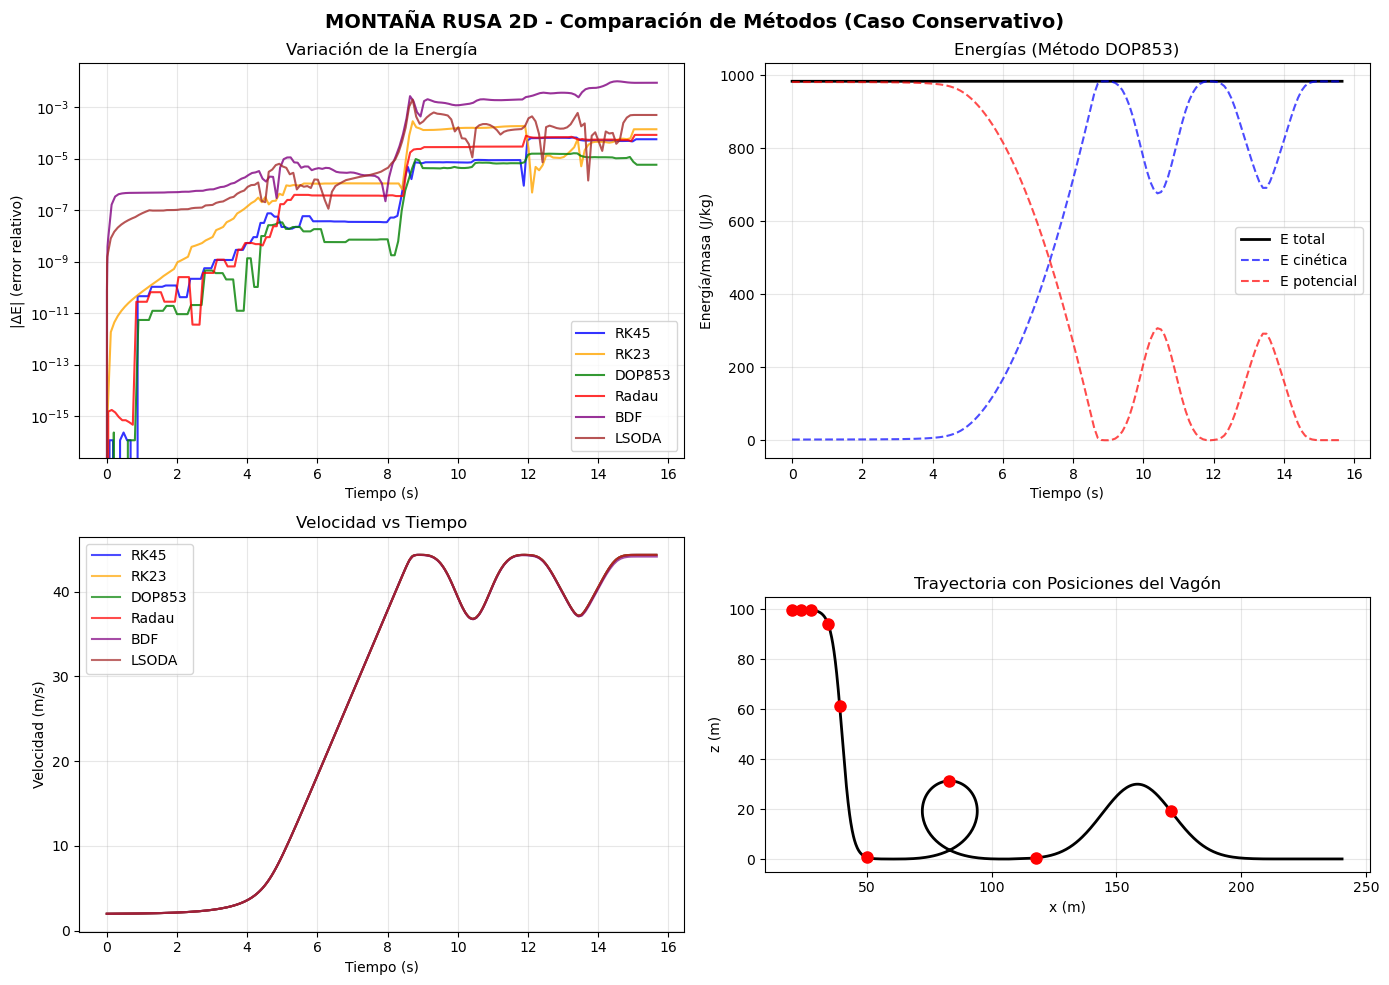

Método seleccionado: DOP853


In [2]:
class SimuladorConservativo:
    """
    Simulador para el caso conservativo (sin fricción ni resistencia aerodinámica)
    """
    
    METODOS = ['RK45', 'RK23', 'DOP853', 'Radau', 'BDF', 'LSODA']
    
    def __init__(self, montaña_rusa, v0=2.0, grav=9.81):
        """
        montaña_rusa: objeto con la trayectoria
        v0: velocidad inicial (m/s)
        grav: aceleración de la gravedad (m/s**2)
        """
        self.mr = montaña_rusa
        self.v0 = v0
        self.grav = grav
        self.bspline = montaña_rusa.bspline
        self.derivadas = mrusa.trayec_der(self.bspline)
        self.resultados = {}
    
    def resolver(self, metodo, tfin=100, max_step=0.1):
        """
        Resuelve la EDO con el método especificado en el caso conservativo
        EDO del sistema (ecuación 6): d/dt [u, v] = [v/||r'||, -g(k·t)]
        k es el vector unitario vertical y t es el vector tangente.
        """

        # Caso conservativo
        coefRoz = 0.0  # μ = 0
        coefVis = 0.0  # ca*Sf*ρa/(2m) = 0
        
        # Condiciones iniciales
        y0 = [0.0, self.v0]
        tspan = [0, tfin]
        
        # Resolver
        sol = scin.solve_ivp(
            mrusa.edofun_mr,
            tspan,
            y0,
            method=metodo,
            args=[self.derivadas, coefRoz, coefVis, self.grav],
            events=[mrusa.finalVia, mrusa.paradaVagon],
            dense_output=True,
            max_step=max_step
        )
        
        return sol
    
    def calcular_energia(self, sol):
        """
        Calcula la energía mecánica por unidad de masa.       
        En el caso conservativo, E_T debe ser constante.
        E_T = E_c + E_p = (1/2)v**2 + g*z
        """
        t = sol.t
        u = sol.y[0]
        v = sol.y[1]
        
        # Obtener z(u) de la curva
        z = self.bspline(u)[:, 2]
        
        E_cinetica = 0.5 * v**2
        E_potencial = self.grav * z
        E_total = E_cinetica + E_potencial
        
        return t, E_total, E_cinetica, E_potencial
    
    def calcular_error_energia(self, E_total):
        """
        Calcula el error relativo de energía.
        inc_E = (E_T(t0) - E_T(t)) / E_T(t0)
        """
        E0 = E_total[0]
        return (E0 - E_total) / E0
    
    def comparar_metodos(self):
        print("\n" + "="*70)
        print("COMPARACIÓN DE MÉTODOS - CASO CONSERVATIVO")
        print("="*70)
        print(f"Parámetros: v0={self.v0} m/s, g={self.grav} m/s², μ=0, ca=0")
        print("-"*70)
        
        for metodo in self.METODOS:
            print(f"Resolviendo con {metodo}...", end=" ")
            
            try:
                sol = self.resolver(metodo)
                t, E_total, E_cin, E_pot = self.calcular_energia(sol)
                error = self.calcular_error_energia(E_total)
                
                self.resultados[metodo] = {
                    'sol': sol,
                    't': t,
                    'E_total': E_total,
                    'E_cinetica': E_cin,
                    'E_potencial': E_pot,
                    'error': error,
                    'n_pasos': len(t),
                    'exito': sol.success
                }
                
                print(f"OK - {len(t)} pasos, t_final={t[-1]:.2f}s")
                
            except Exception as e:
                print(f"ERROR: {e}")
                self.resultados[metodo] = None
        
        return self.resultados
    
    def generar_tabla(self):
        print("\n" + "="*90)
        print("TABLA RESUMEN DE RESULTADOS")
        print("="*90)
        print(f"{'Método':<10} {'Pasos':>8} {'ΔE_mín':>12} {'ΔE_máx':>12} "
              f"{'ΔE_medio':>12} {'σ(ΔE)':>12}")
        print("-"*90)
        
        tabla = []
        for metodo in self.METODOS:
            res = self.resultados.get(metodo)
            if res is not None:
                error = res['error']
                fila = {
                    'metodo': metodo,
                    'pasos': res['n_pasos'],
                    'error_min': error.min(),
                    'error_max': error.max(),
                    'error_medio': error.mean(),
                    'error_std': error.std()
                }
                tabla.append(fila)
                
                print(f"{metodo:<10} {fila['pasos']:>8} {fila['error_min']:>+12.1e} "
                      f"{fila['error_max']:>+12.1e} {fila['error_medio']:>+12.1e} "
                      f"{fila['error_std']:>+12.1e}")
        
        print("-"*90)
        
        # Mejor método (menor σ)
        mejor = min(tabla, key=lambda x: x['error_std'])
        print(f"\n→ MEJOR MÉTODO: {mejor['metodo']} (σ(ΔE) = {mejor['error_std']:.1e})")
        
        self.tabla = tabla
        self.mejor_metodo = mejor['metodo']
        return tabla

    def visualizar(self, guardar=True):
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        
        colores = {
            'RK45': 'blue', 'RK23': 'orange', 'DOP853': 'green',
            'Radau': 'red', 'BDF': 'purple', 'LSODA': 'brown'
        }
        
        # 1. Error de energía (escala logarítmica)
        ax1 = axes[0, 0]
        for metodo, res in self.resultados.items():
            if res is not None:
                ax1.semilogy(res['t'], np.abs(res['error']), label=metodo, color=colores[metodo], alpha=0.8)
        ax1.set_xlabel('Tiempo (s)')
        ax1.set_ylabel('|ΔE| (error relativo)')
        ax1.set_title('Variación de la Energía')
        ax1.legend(loc='best')
        ax1.grid(True, alpha=0.3)
        
        # 2. Energías (mejor método)
        ax2 = axes[0, 1]
        mejor = self.mejor_metodo
        if mejor in self.resultados and self.resultados[mejor]:
            res = self.resultados[mejor]
            ax2.plot(res['t'], res['E_total'], 'k-', label='E total', lw=2)
            ax2.plot(res['t'], res['E_cinetica'], 'b--', label='E cinética', alpha=0.7)
            ax2.plot(res['t'], res['E_potencial'], 'r--', label='E potencial', alpha=0.7)
        ax2.set_xlabel('Tiempo (s)')
        ax2.set_ylabel('Energía/masa (J/kg)')
        ax2.set_title(f'Energías (Método {mejor})')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # 3. Velocidad vs tiempo
        ax3 = axes[1, 0]
        for metodo, res in self.resultados.items():
            if res is not None:
                ax3.plot(res['t'], res['sol'].y[1], label=metodo, 
                        color=colores[metodo], alpha=0.7)
        ax3.set_xlabel('Tiempo (s)')
        ax3.set_ylabel('Velocidad (m/s)')
        ax3.set_title('Velocidad vs Tiempo')
        ax3.legend(loc='best')
        ax3.grid(True, alpha=0.3)
        
        # 4. Trayectoria
        ax4 = axes[1, 1]
        u_curva = np.linspace(0, 1, 500)
        pos = self.bspline(u_curva)
        ax4.plot(pos[:, 0], pos[:, 2], 'k-', lw=2, label='Trayectoria')
        
        # Posiciones del vagón
        if mejor in self.resultados and self.resultados[mejor]:
            sol = self.resultados[mejor]['sol']
            t_marcas = np.linspace(0, sol.t[-1], 10)
            for t_m in t_marcas:
                u_m = sol.sol(t_m)[0]
                if 0 <= u_m <= 1:
                    p = self.bspline(u_m)
                    ax4.plot(p[0], p[2], 'ro', ms=8)
        
        ax4.set_xlabel('x (m)')
        ax4.set_ylabel('z (m)')
        ax4.set_title('Trayectoria con Posiciones del Vagón')
        ax4.set_aspect('equal', adjustable='box')
        ax4.grid(True, alpha=0.3)
        
        plt.suptitle('MONTAÑA RUSA 2D - Comparación de Métodos (Caso Conservativo)',  fontsize=14, fontweight='bold')
        plt.tight_layout()
        
        if guardar:
            plt.savefig('montaña_rusa_2D_2.png', dpi=150, bbox_inches='tight')
        
        plt.show()
        return fig


# 1. Crear la montaña rusa
mr = MontañaRusa2D("Montaña Rusa 2D")
mr.agregar_segmento(Sigmoide(A=100, m=0.5, u_min=-20, u_max=20))
mr.agregar_segmento(Clotoide(A=35))
mr.agregar_segmento(Gaussiana(A=30, s=20, u_min=-52, u_max=52))
mr.agregar_segmento(Recta(longitud=30, pendiente=0))
mr.construir(x_inicio=20, z_inicio=0, n_puntos_por_segmento=50)
mr.crear_bspline(suavizado=0, grado=3)

# 2. Crear el simulador y comparar los métodos
sim = SimuladorConservativo(mr, v0=2.0, grav=9.81)
sim.comparar_metodos()
    
# 3. Generar la tabla de resultados
sim.generar_tabla()
    
# 4. Visualización
sim.visualizar(guardar=True)

plt.show()

print(f"Método seleccionado: {sim.mejor_metodo}")


----------------------------------------------------------------------
RESUMEN:
  Longitud total en X: 220.4 m
  Altura máxima: 100.0 m
  Altura mínima: 0.0 m
  Número total de puntos: 246
----------------------------------------------------------------------
B-SPLINE CREADO:
  Grado: 3
  Número de nodos: 250
  Dominio u: [0.0000, 1.0000]
  Suavizado: 0
----------------------------------------------------------------------
VERIFICACIÓN DE INTERPOLACIÓN:
  Error máximo en x: 8.53e-14 m
  Error máximo en z: 4.26e-14 m
  Interpolación exacta

Simulando con DOP853...
Parámetros: m=800kg, v0=2.0m/s, μ=0.015, ca=0.4, cv=6.13e-04

RESULTADOS DE LA SIMULACIÓN
Recorrido completado: 100.0%
Tiempo total: 18.26 s
Velocidad: [1.8, 42.1] m/s
Aceleración máxima: 34.3g
Fuerza normal: [-9.8, 344.3] m/s²

------------------------------------------------------------
ANÁLISIS DE VIABILIDAD
------------------------------------------------------------
Completa el recorrido
Aceleración excesiva: 34.3g (límit

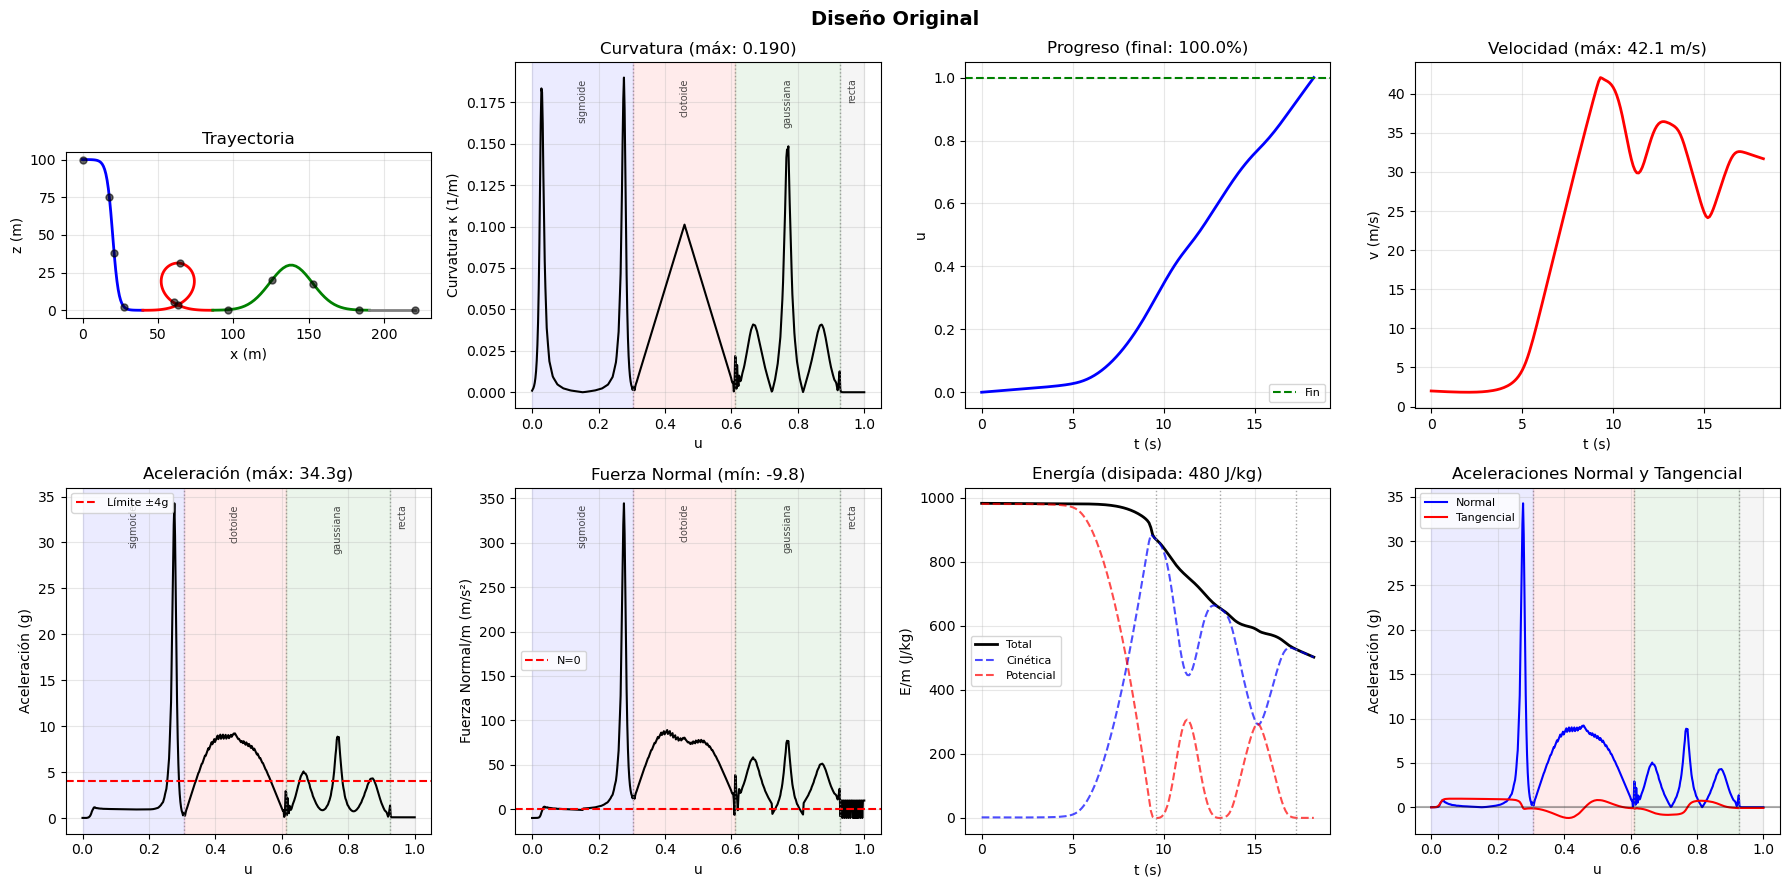

In [3]:
class ParametrosFisicos:
    def __init__(self, masa=800, v0=2.0, mu=0.015, ca=0.4, Sf=2.0, rho_a=1.225, grav=9.81):
        self.masa = masa
        self.v0 = v0
        self.mu = mu
        self.ca = ca
        self.Sf = Sf
        self.rho_a = rho_a
        self.grav = grav
        self.cv = ca * Sf * rho_a / (2 * masa)

    def __str__(self):
        return (f"m={self.masa}kg, v0={self.v0}m/s, μ={self.mu}, ca={self.ca}, cv={self.cv:.2e}")

class Simulador:
    """
    Simulador de la montaña rusa. Resuelve la EDO y analiza su viabilidad.
    """
    ACELERACION_MAXIMA = 4.0
    
    def __init__(self, montaña_rusa, params=None):
        self.mr = montaña_rusa
        self.params = params or ParametrosFisicos()
        self.bspline = montaña_rusa.bspline
        self.derivadas = mrusa.trayec_der(self.bspline)
        self.sol = None
        self.datos = None
    
    def simular(self, metodo='DOP853', tfin=200):
        print(f"\nSimulando con {metodo}...")
        print(f"Parámetros: {self.params}")
        
        self.sol = scin.solve_ivp(
            mrusa.edofun_mr,
            [0, tfin],
            [0.0, self.params.v0],
            method=metodo,
            args=[self.derivadas, self.params.mu, self.params.cv, self.params.grav],
            events=[mrusa.finalVia, mrusa.paradaVagon],
            dense_output=True,
            max_step=0.1
        )
        
        self._calcular_datos()       
        self._mostrar_resultados()
        
        return self
    
    def _calcular_datos(self):
        """Calcula aceleraciones, fuerzas y curvatura a lo largo del recorrido"""
        u = self.sol.y[0]
        v = self.sol.y[1]
        t = self.sol.t
        
        u_max = min(u[-1], 1.0)
        u_eval = np.linspace(0, u_max, 500)
        
        acel_total, acel_tang, acel_normal = [], [], []
        fuerza_normal, tiempos, velocidades = [], [], []
        curvaturas = []
        
        for u_i in u_eval:
            idx = np.argmin(np.abs(u - u_i))
            v_i, t_i = v[idx], t[idx]
            
            try:
                fN, base, ctes = mrusa.fuerzaNormal(u_i, v_i, self.derivadas, self.params.grav)
                acel = mrusa.aceleracion(v_i, base, self.params.mu, self.params.cv, fN, ctes[1], self.params.grav)
                acel_total.append(acel[0])
                acel_tang.append(acel[1])
                acel_normal.append(acel[2])
                fuerza_normal.append(fN)
                # ctes = [norma_r', curvatura, torsión]
                curvaturas.append(ctes[1])
            except:
                acel_total.append(0)
                acel_tang.append(0)
                acel_normal.append(0)
                fuerza_normal.append(0)
                curvaturas.append(0)
            
            tiempos.append(t_i)
            velocidades.append(v_i)
        
        self.datos = {
            'u': u_eval,
            't': np.array(tiempos),
            'v': np.array(velocidades),
            'acel_total': np.array(acel_total),
            'acel_tang': np.array(acel_tang),
            'acel_normal': np.array(acel_normal),
            'fuerza_normal': np.array(fuerza_normal),
            'curvatura': np.array(curvaturas)
        }
    
    def _mostrar_resultados(self):
        """Muestra resumen de resultados."""
        u_final = self.sol.y[0][-1]
        v = self.sol.y[1]
        g = self.params.grav
        
        print(f"\n{'='*60}")
        print("RESULTADOS DE LA SIMULACIÓN")
        print(f"{'='*60}")
        print(f"Recorrido completado: {u_final*100:.1f}%")
        print(f"Tiempo total: {self.sol.t[-1]:.2f} s")
        print(f"Velocidad: [{v.min():.1f}, {v.max():.1f}] m/s")
        print(f"Aceleración máxima: {self.datos['acel_total'].max()/g:.1f}g")
        print(f"Fuerza normal: [{self.datos['fuerza_normal'].min():.1f}, "
              f"{self.datos['fuerza_normal'].max():.1f}] m/s²")
        
        print(f"\n{'-'*60}")
        print("ANÁLISIS DE VIABILIDAD")
        print(f"{'-'*60}")
        
        viable = True
        
        # ¿Completa el recorrido?
        if u_final < 0.99:
            viable = False
            pos = self.bspline(u_final)
            print(f"NO COMPLETA: Se detiene en u={u_final:.3f} (x={pos[0]:.1f}m, z={pos[2]:.1f}m)")
        else:
            print(f"Completa el recorrido")
        
        # Aceleraciones
        acel_g = self.datos['acel_total'] / g
        acel_n_g = self.datos['acel_normal'] / g
        
        if acel_n_g.max() > self.ACELERACION_MAXIMA:
            viable = False
            print(f"Aceleración excesiva: {acel_n_g.max():.1f}g (límite: {self.ACELERACION_MAXIMA}g)")
        else:
            print(f"Aceleración: {acel_n_g.max():.1f}g (límite: {self.ACELERACION_MAXIMA}g)")
        
        # Fuerza normal negativa (solo informativo)
        if self.datos['fuerza_normal'].min() < 0:
            print(f"Fuerza normal negativa: up-stop wheels activas")
        
        print(f"\nVIABLE: {'SÍ' if viable else 'NO'}")
        
        return viable
    
    def _get_limites_segmentos(self):
        """Calcula los límites de u para cada segmento."""
        limites = [0.0]
        
        # Evalua el bspline en muchos puntos
        u_test = np.linspace(0, 1, 2000)
        x_test = self.bspline(u_test)[:, 0]
        
        # Para cada segmento, busca el u correspondiente a su x final
        for seg in self.mr.segmentos:
            x_fin_seg = seg.x[-1]
            # Buscar el u más cercano a este x
            idx = np.argmin(np.abs(x_test - x_fin_seg))
            limites.append(u_test[idx])
        
        # Asegurar que el último es 1.0
        limites[-1] = 1.0
        
        return limites
    
    def _dibujar_separadores(self, ax, limites, vertical=True, labels=True):
        colores_seg = ['blue', 'red', 'green', 'gray', 'purple', 'orange']
        nombres = [seg.nombre.split('(')[0] for seg in self.mr.segmentos]
        
        for i, u_lim in enumerate(limites[1:-1], 1):
            ax.axvline(u_lim, color='gray', ls=':', alpha=0.7, lw=1)
        
        for i in range(len(limites) - 1):
            color = colores_seg[i % len(colores_seg)]
            ax.axvspan(limites[i], limites[i+1], alpha=0.08, color=color)
            if labels and i < len(nombres):
                u_mid = (limites[i] + limites[i+1]) / 2
                ymin, ymax = ax.get_ylim()
                ax.text(u_mid, ymax * 0.95, nombres[i], ha='center', va='top', fontsize=7, alpha=0.7, rotation=90)
    
    def visualizar(self, guardar=True):
        fig, axes = plt.subplots(2, 4, figsize=(18, 9))
        
        t = self.sol.t
        u = self.sol.y[0]
        v = self.sol.y[1]
        g = self.params.grav
        
        limites_u = self._get_limites_segmentos()
        
        # 1. Trayectoria (colorear por segmentos)
        ax = axes[0, 0]
        colores_seg = ['blue', 'red', 'green', 'gray', 'purple', 'orange']
        for i, seg in enumerate(self.mr.segmentos):
            ax.plot(seg.x, seg.z, '-', color=colores_seg[i % len(colores_seg)], lw=2, label=seg.nombre.split('(')[0])
        # Posiciones del vagón
        for u_v in np.linspace(0, u[-1], 12):
            p = self.bspline(u_v)
            ax.plot(p[0], p[2], 'ko', ms=5, alpha=0.6)
        ax.set_xlabel('x (m)')
        ax.set_ylabel('z (m)')
        ax.set_title('Trayectoria')
        #ax.legend(fontsize=7, loc='upper right')
        ax.set_aspect('equal', adjustable='box')
        ax.grid(True, alpha=0.3)
        
        # 2. Curvatura (con separadores de segmentos)
        ax = axes[0, 1]
        curv = self.datos['curvatura']
        ax.plot(self.datos['u'], curv, 'k-', lw=1.5)
        ax.set_xlabel('u')
        ax.set_ylabel('Curvatura κ (1/m)')
        ax.set_title(f'Curvatura (máx: {curv.max():.3f})')
        ax.grid(True, alpha=0.3)
        self._dibujar_separadores(ax, limites_u, labels=True)
        
        # 3. u(t)
        ax = axes[0, 2]
        ax.plot(t, u, 'b-', lw=2)
        ax.axhline(1, color='g', ls='--', label='Fin')
        ax.set_xlabel('t (s)')
        ax.set_ylabel('u')
        ax.set_title(f'Progreso (final: {u[-1]*100:.1f}%)')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
        
        # 4. v(t)
        ax = axes[0, 3]
        ax.plot(t, v, 'r-', lw=2)
        ax.set_xlabel('t (s)')
        ax.set_ylabel('v (m/s)')
        ax.set_title(f'Velocidad (máx: {v.max():.1f} m/s)')
        ax.grid(True, alpha=0.3)
        
        # 5. Aceleración (con separadores de segmentos)
        ax = axes[1, 0]
        acel_g = self.datos['acel_total'] / g
        ax.plot(self.datos['u'], acel_g, 'k-', lw=1.5)
        ax.axhline(4, color='r', ls='--', label='Límite ±4g')
        #ax.axhline(-4, color='r', ls='--')
        ax.set_xlabel('u')
        ax.set_ylabel('Aceleración (g)')
        ax.set_title(f'Aceleración (máx: {acel_g.max():.1f}g)')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
        self._dibujar_separadores(ax, limites_u, labels=True)
        
        # 6. Fuerza normal (con separadores de segmentos)
        ax = axes[1, 1]
        fN = self.datos['fuerza_normal']
        ax.plot(self.datos['u'], fN, 'k-', lw=1.5)
        ax.axhline(0, color='r', ls='--', label='N=0')
        ax.set_xlabel('u')
        ax.set_ylabel('Fuerza Normal/m (m/s²)')
        ax.set_title(f'Fuerza Normal (mín: {fN.min():.1f})')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
        self._dibujar_separadores(ax, limites_u, labels=True)
        
        # 7. Energía (con separadores por tiempo)
        ax = axes[1, 2]
        z = self.bspline(u)[:, 2]
        E_cin = 0.5 * v**2
        E_pot = g * z
        E_total = E_cin + E_pot
        ax.plot(t, E_total, 'k-', lw=2, label='Total')
        ax.plot(t, E_cin, 'b--', alpha=0.7, label='Cinética')
        ax.plot(t, E_pot, 'r--', alpha=0.7, label='Potencial')
        ax.set_xlabel('t (s)')
        ax.set_ylabel('E/m (J/kg)')
        ax.set_title(f'Energía (disipada: {E_total[0]-E_total[-1]:.0f} J/kg)')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
        # Separadores por tiempo para energía
        for i, u_lim in enumerate(limites_u[1:-1], 1):
            idx = np.argmin(np.abs(self.sol.y[0] - u_lim))
            if idx < len(t):
                ax.axvline(t[idx], color='gray', ls=':', alpha=0.7, lw=1)
        
        # 8. Aceleración normal vs tangencial
        ax = axes[1, 3]
        acel_n_g = self.datos['acel_normal'] / g
        acel_t_g = self.datos['acel_tang'] / g
        ax.plot(self.datos['u'], acel_n_g, 'b-', lw=1.5, label='Normal')
        ax.plot(self.datos['u'], acel_t_g, 'r-', lw=1.5, label='Tangencial')
        ax.axhline(0, color='k', ls='-', alpha=0.3)
        ax.set_xlabel('u')
        ax.set_ylabel('Aceleración (g)')
        ax.set_title('Aceleraciones Normal y Tangencial')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
        self._dibujar_separadores(ax, limites_u, labels=False)
        
        plt.suptitle(f'{self.mr.nombre}', fontsize=14, fontweight='bold')
        plt.tight_layout()
        
        if guardar:
            plt.savefig('montaña_rusa_2D_3.png', dpi=150, bbox_inches='tight')
        
        plt.show()
        return fig


mr = MontañaRusa2D("Diseño Original")
mr.agregar_segmento(Sigmoide(A=100, m=0.5))
mr.agregar_segmento(Clotoide(A=35))
mr.agregar_segmento(Gaussiana(A=30, s=20))
mr.agregar_segmento(Recta(longitud=30))  
mr.construir()
mr.crear_bspline(suavizado=0, grado=3)
mr.verificar_interpolacion()
#mr.visualizar(guardar=True)

params = ParametrosFisicos()
    
sim = Simulador(mr, params)
sim.simular(metodo='DOP853')
sim.visualizar()

plt.show()

----------------------------------------------------------------------
RESUMEN:
  Longitud total en X: 1052.3 m
  Altura máxima: 119.2 m
  Altura mínima: 0.2 m
  Número total de puntos: 491
----------------------------------------------------------------------
B-SPLINE CREADO:
  Grado: 3
  Número de nodos: 495
  Dominio u: [0.0000, 1.0000]
  Suavizado: 0
----------------------------------------------------------------------
VERIFICACIÓN DE INTERPOLACIÓN:
  Error máximo en x: 5.68e-13 m
  Error máximo en z: 2.84e-14 m
  Interpolación exacta


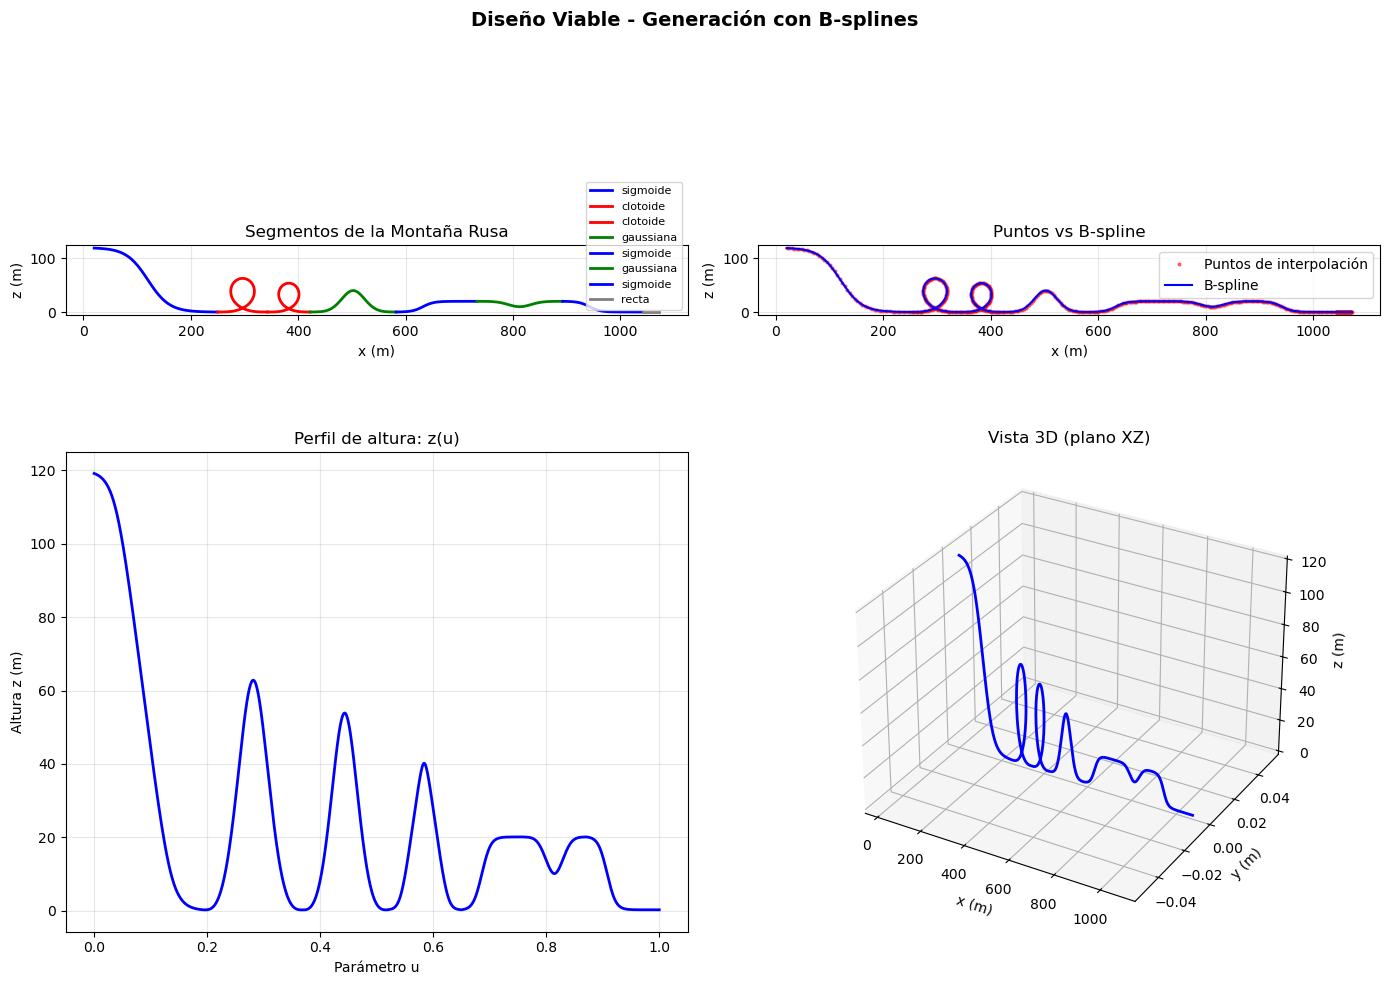


Simulando con DOP853...
Parámetros: m=800kg, v0=2.0m/s, μ=0.015, ca=0.4, cv=6.13e-04

RESULTADOS DE LA SIMULACIÓN
Recorrido completado: 100.0%
Tiempo total: 72.24 s
Velocidad: [2.0, 44.1] m/s
Aceleración máxima: 3.7g
Fuerza normal: [-9.8, 41.6] m/s²

------------------------------------------------------------
ANÁLISIS DE VIABILIDAD
------------------------------------------------------------
Completa el recorrido
Aceleración: 3.6g (límite: 4.0g)
Fuerza normal negativa: up-stop wheels activas

VIABLE: SÍ


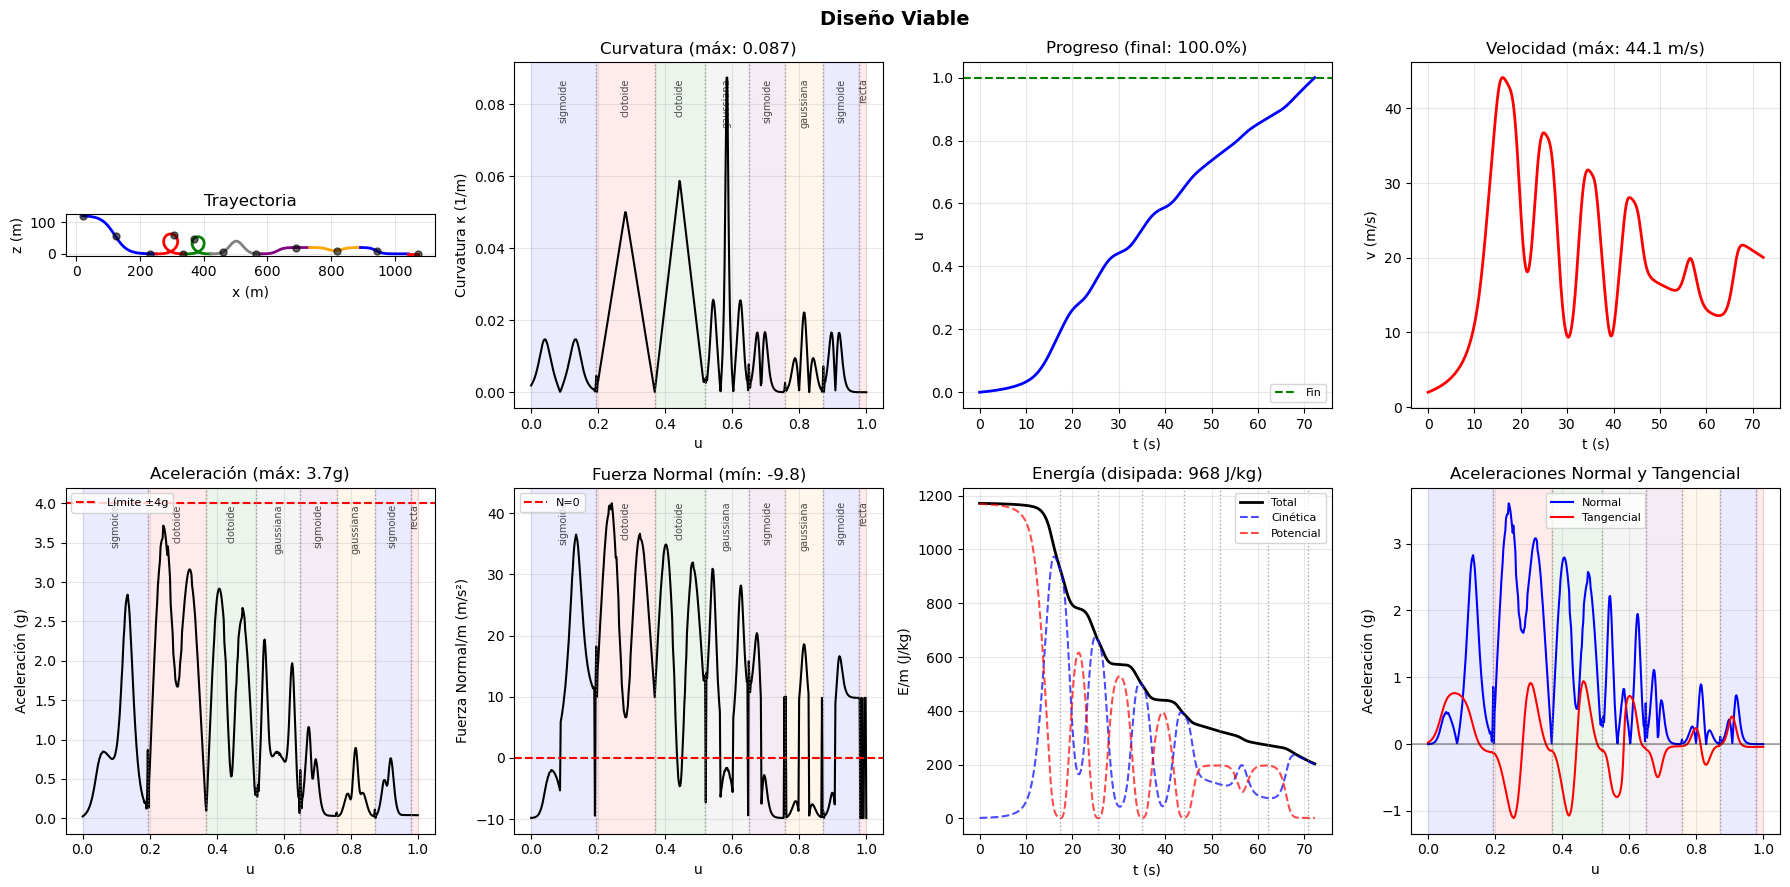

In [4]:
mr = MontañaRusa2D("Diseño Viable")

class SigmoideModif(Sigmoide):
    def generar(self, x0, z0, n_puntos=50):
        u = np.linspace(self.u_min, self.u_max, n_puntos)
        
        x_sig, z_sig = curvas.sigmoide(u, A=abs(self.A), s=self.m)

        self.x = x_sig + x0 - self.u_min
        if self.A >= 0:
            self.z = z_sig - z_sig[0] + z0
        else:
            self.z = z_sig[0] - z_sig + z0
        
        return self.x, self.z

mr.agregar_segmento(Sigmoide(A=120, m=0.05, u_min=-100, u_max=130))
mr.agregar_segmento(Clotoide(A=70))
mr.agregar_segmento(Clotoide(A=60))
mr.agregar_segmento(Gaussiana(A=40, s=30, u_min=-80, u_max=80))
mr.agregar_segmento(SigmoideModif(A=-20, m=0.1, u_min=-50, u_max=100))
mr.agregar_segmento(Gaussiana(A=-10, s=30, u_min=-80, u_max=80))
mr.agregar_segmento(SigmoideModif(A=20, m=0.1, u_min=-50, u_max=100))
mr.agregar_segmento(Recta(longitud=30))

mr.construir(x_inicio=20, z_inicio=0, n_puntos_por_segmento=50)
mr.crear_bspline(suavizado=0, grado=3)
mr.verificar_interpolacion()
mr.visualizar()

params = ParametrosFisicos()
    
sim = Simulador(mr, params)
sim.simular(metodo='DOP853')
sim.visualizar()

plt.show()


──────────────────────────────────────────────────────────────────────

VARIANDO: masa
Valores base: m=800kg, μ=0.015, ca=0.4, Sf=2.0m², v0=2.0m/s
Rango de análisis: masa ∈ [400.00, 1200.00]
----------------------------------------------------------------------
Valor nominal: 800.00 → usando 786.21
Estrategia: Nominal → Máximo, luego Nominal → Mínimo
----------------------------------------------------------------------

FASE 1: Explorando hacia valores CRECIENTES...
  [OK]  masa=786.21: u=100.0%, acel= 3.6g
  [OK]  masa=868.97: u=100.0%, acel= 3.8g
  [OK]  masa=951.72: u=100.0%, acel= 3.8g
  [OK]  masa=1034.48: u=100.0%, acel= 3.8g
  [NO]  masa=1117.24: u=100.0%, acel= 4.1g (>4g)
  [NO]  masa=1200.00: u=100.0%, acel= 4.1g (>4g)

FASE 2: Explorando hacia valores DECRECIENTES...
  [OK]  masa=731.03: u=100.0%, acel= 3.6g
  [OK]  masa=675.86: u=100.0%, acel= 3.4g
  [NO]  masa=648.28: u=43.9%, acel= 3.4g (NO completa)
  [NO]  masa=620.69: u=43.7%, acel= 3.4g (NO completa)
  Límite inferio

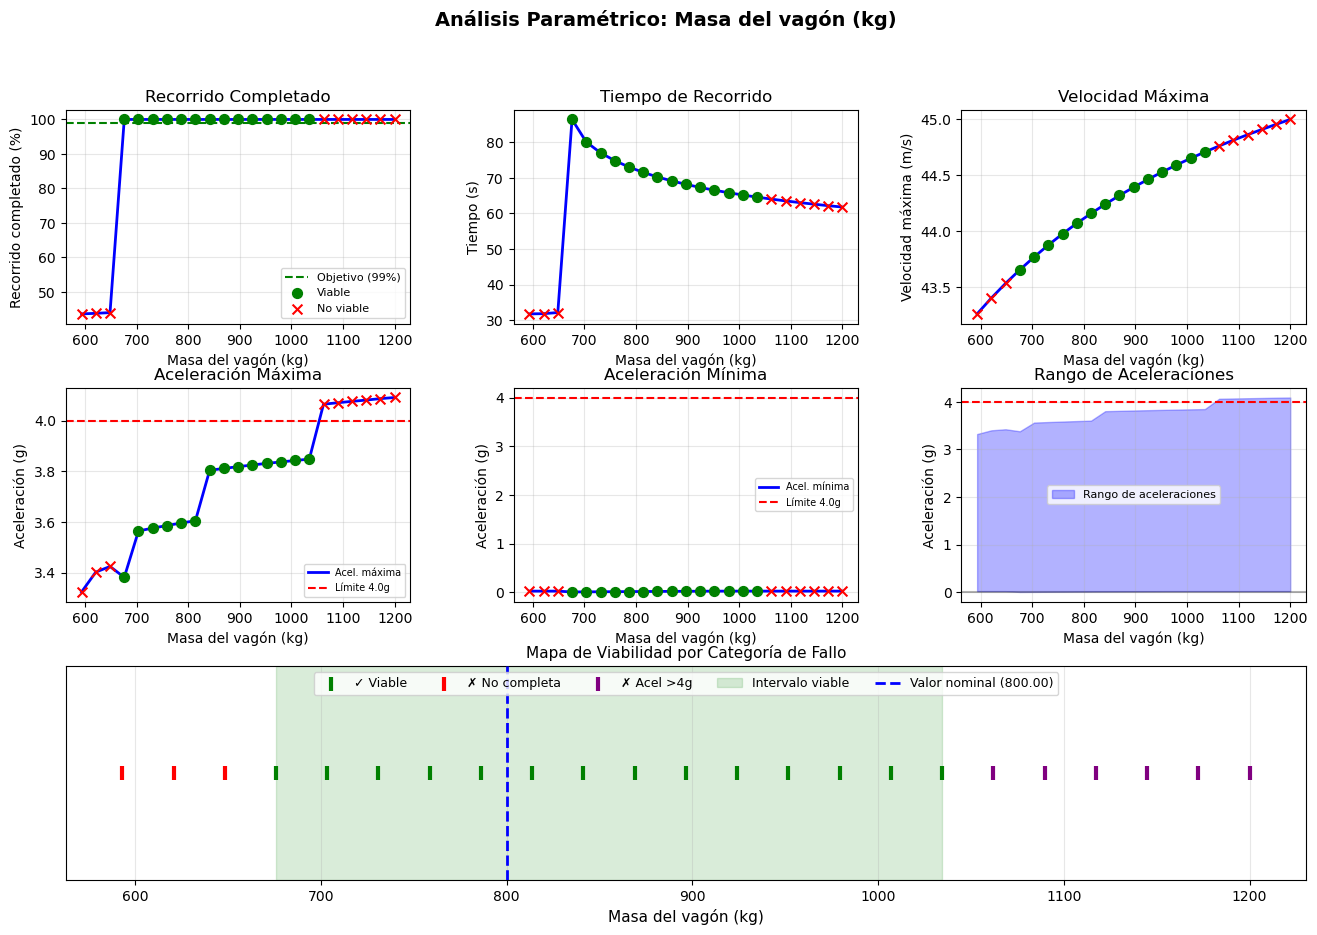


──────────────────────────────────────────────────────────────────────

VARIANDO: mu
Valores base: m=800kg, μ=0.015, ca=0.4, Sf=2.0m², v0=2.0m/s
Rango de análisis: mu ∈ [0.00, 0.05]
----------------------------------------------------------------------
Valor nominal: 0.01 → usando 0.01
Estrategia: Nominal → Máximo, luego Nominal → Mínimo
----------------------------------------------------------------------

FASE 1: Explorando hacia valores CRECIENTES...
  [OK]  mu=  0.01: u=100.0%, acel= 3.7g
  [NO]  mu=  0.02: u=44.1%, acel= 3.5g (NO completa)
  Límite superior alcanzado en mu=0.02

FASE 2: Explorando hacia valores DECRECIENTES...
  [OK]  mu=  0.01: u=100.0%, acel= 3.7g
  [OK]  mu=  0.01: u=100.0%, acel= 3.7g
  [OK]  mu=  0.01: u=100.0%, acel= 3.9g
  [OK]  mu=  0.01: u=100.0%, acel= 3.9g
  [OK]  mu=  0.01: u=100.0%, acel= 3.9g
  [OK]  mu=  0.00: u=100.0%, acel= 4.0g
  [OK]  mu=  0.00: u=100.0%, acel= 4.0g
  [NO]  mu=  0.00: u=100.0%, acel= 4.0g (>4g)

───────────────────────────────

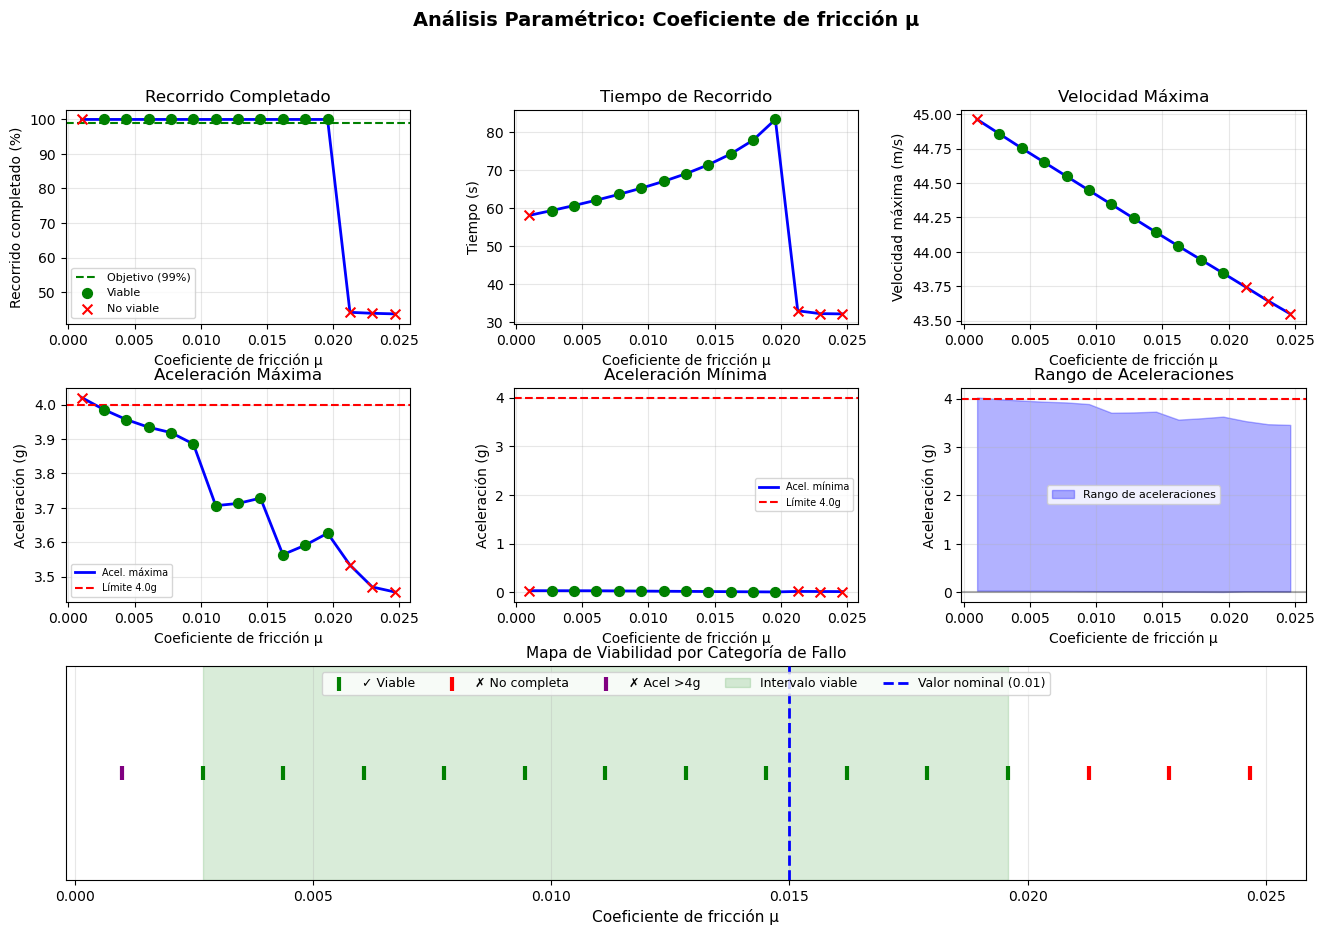


──────────────────────────────────────────────────────────────────────

VARIANDO: ca
Valores base: m=800kg, μ=0.015, ca=0.4, Sf=2.0m², v0=2.0m/s
Rango de análisis: ca ∈ [0.05, 1.50]
----------------------------------------------------------------------
Valor nominal: 0.40 → usando 0.40
Estrategia: Nominal → Máximo, luego Nominal → Mínimo
----------------------------------------------------------------------

FASE 1: Explorando hacia valores CRECIENTES...
  [OK]  ca=  0.40: u=100.0%, acel= 3.6g
  [NO]  ca=  0.50: u=43.9%, acel= 3.5g (NO completa)
  [NO]  ca=  0.60: u=43.3%, acel= 3.2g (NO completa)
  Límite superior alcanzado en ca=0.60

FASE 2: Explorando hacia valores DECRECIENTES...
  [OK]  ca=  0.35: u=100.0%, acel= 3.8g
  [NO]  ca=  0.30: u=100.0%, acel= 4.1g (>4g)
  [NO]  ca=  0.25: u=100.0%, acel= 4.1g (>4g)
  [NO]  ca=  0.20: u=100.0%, acel= 4.4g (>4g)
  [NO]  ca=  0.15: u=100.0%, acel= 4.6g (>4g)
  [NO]  ca=  0.10: u=100.0%, acel= 5.2g (>4g)
  [NO]  ca=  0.05: u=100.0%, acel= 

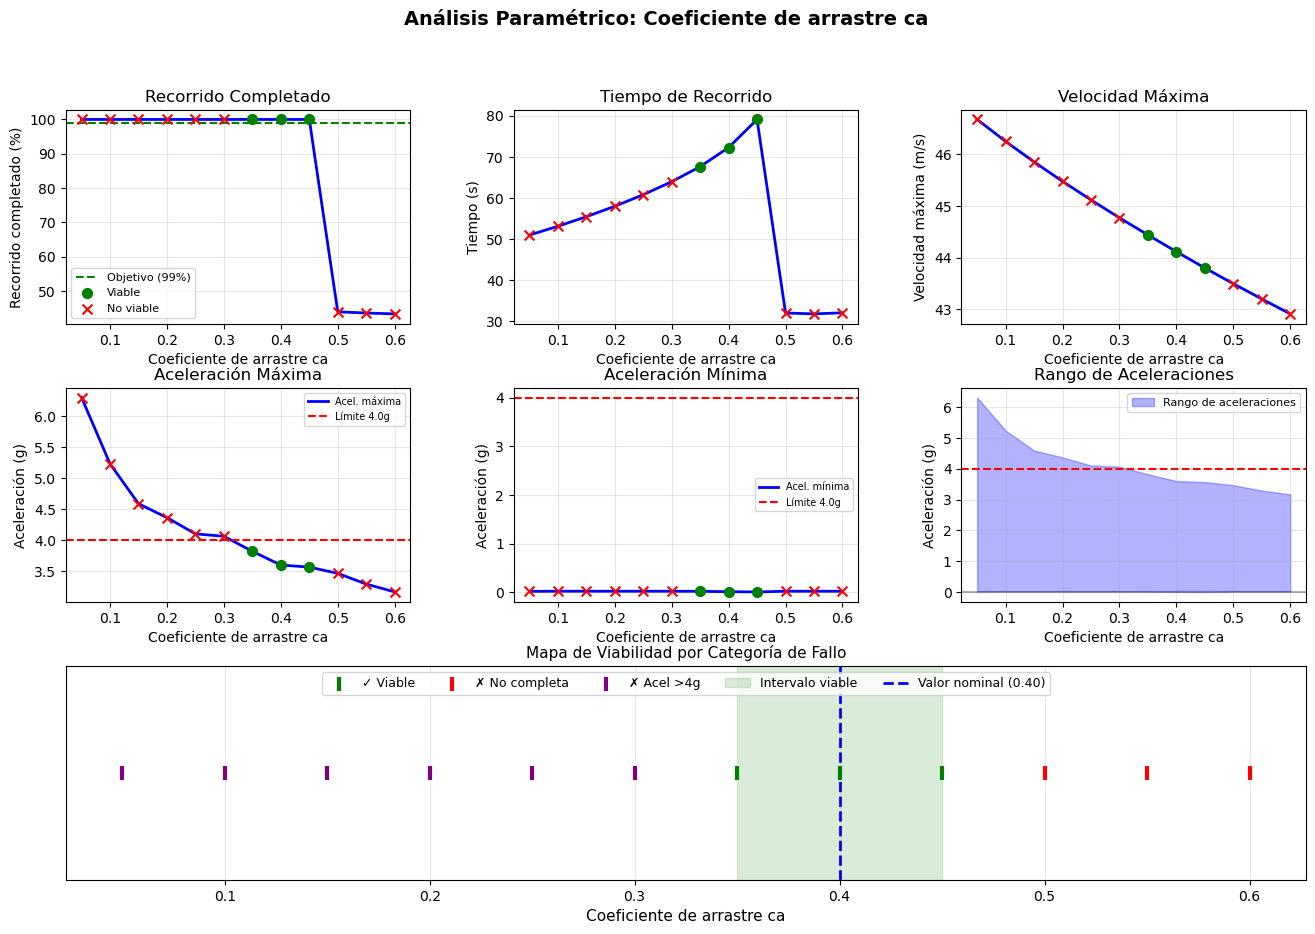


──────────────────────────────────────────────────────────────────────

VARIANDO: Sf
Valores base: m=800kg, μ=0.015, ca=0.4, Sf=2.0m², v0=2.0m/s
Rango de análisis: Sf ∈ [0.50, 5.00]
----------------------------------------------------------------------
Valor nominal: 2.00 → usando 2.05
Estrategia: Nominal → Máximo, luego Nominal → Mínimo
----------------------------------------------------------------------

FASE 1: Explorando hacia valores CRECIENTES...
  [OK]  Sf=  2.05: u=100.0%, acel= 3.6g
  [NO]  Sf=  2.52: u=43.8%, acel= 3.5g (NO completa)
  [NO]  Sf=  2.67: u=43.6%, acel= 3.3g (NO completa)
  Límite superior alcanzado en Sf=2.83

FASE 2: Explorando hacia valores DECRECIENTES...
  [OK]  Sf=  1.74: u=100.0%, acel= 3.8g
  [NO]  Sf=  1.43: u=100.0%, acel= 4.1g (>4g)
  [NO]  Sf=  1.12: u=100.0%, acel= 4.3g (>4g)
  [NO]  Sf=  0.81: u=100.0%, acel= 4.4g (>4g)
  [NO]  Sf=  0.50: u=100.0%, acel= 5.2g (>4g)

──────────────────────────────────────────────────────────────────────
→ INTERVA

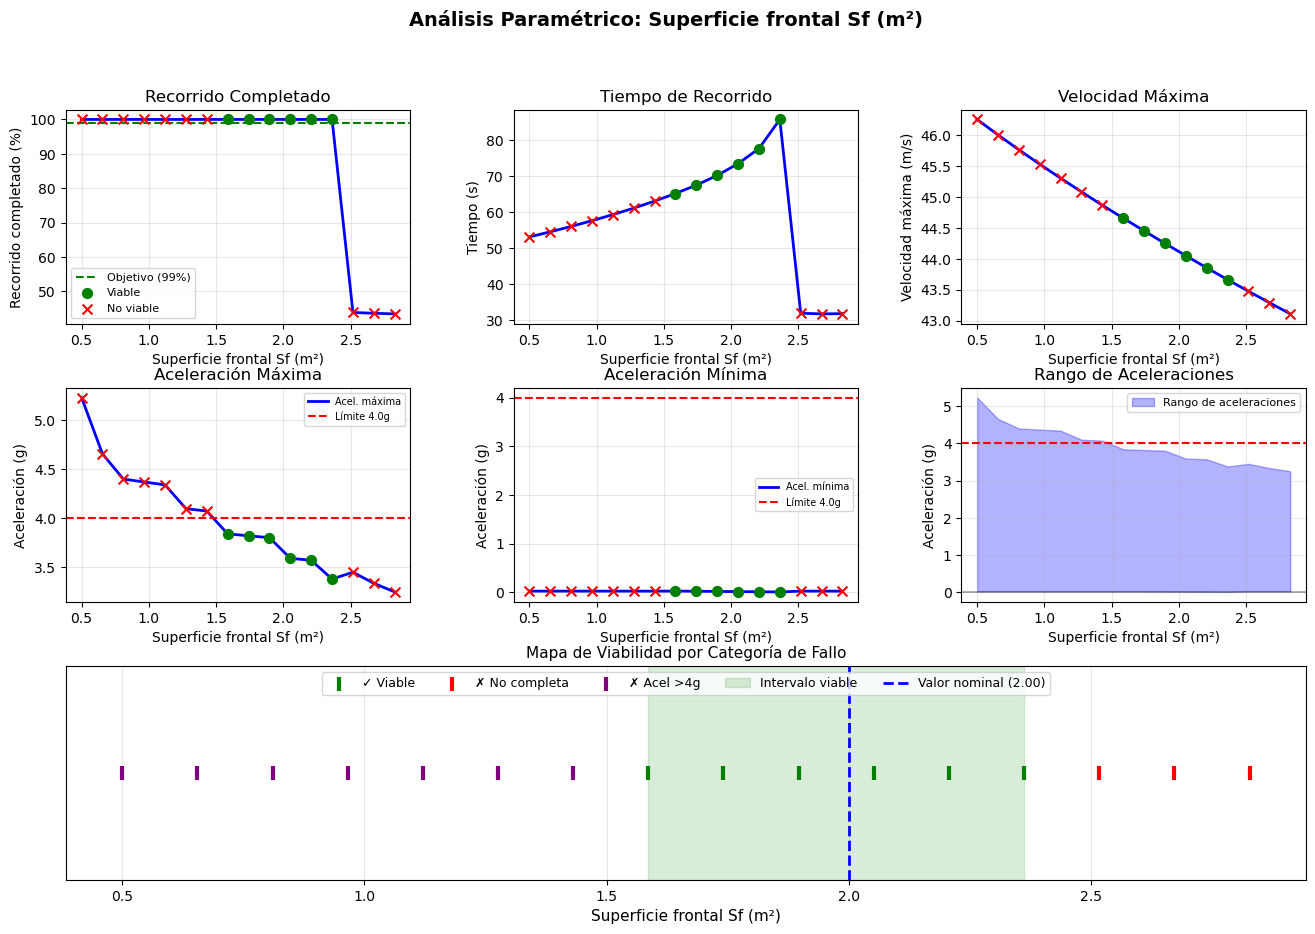


──────────────────────────────────────────────────────────────────────
NOTA: Velocidad inicial - verificando si se estanca al inicio
      (Con descenso A=100m, la energía potencial domina sobre v0)

VARIANDO: v0
Valores base: m=800kg, μ=0.015, ca=0.4, Sf=2.0m², v0=2.0m/s
Rango de análisis: v0 ∈ [0.01, 8.00]
----------------------------------------------------------------------
Valor nominal: 2.00 → usando 2.06
Estrategia: Nominal → Máximo, luego Nominal → Mínimo
----------------------------------------------------------------------

FASE 1: Explorando hacia valores CRECIENTES...
  [OK]  v0=  2.06: u=100.0%, acel= 3.6g
  [OK]  v0=  3.29: u=100.0%, acel= 3.7g
  [OK]  v0=  4.52: u=100.0%, acel= 3.6g
  [OK]  v0=  5.75: u=100.0%, acel= 3.6g
  [OK]  v0=  6.98: u=100.0%, acel= 3.6g

FASE 2: Explorando hacia valores DECRECIENTES...
  [OK]  v0=  1.65: u=100.0%, acel= 3.7g
  [OK]  v0=  1.24: u=100.0%, acel= 3.6g
  [OK]  v0=  0.83: u=100.0%, acel= 3.6g
  [OK]  v0=  0.42: u=100.0%, acel= 3.6g
  

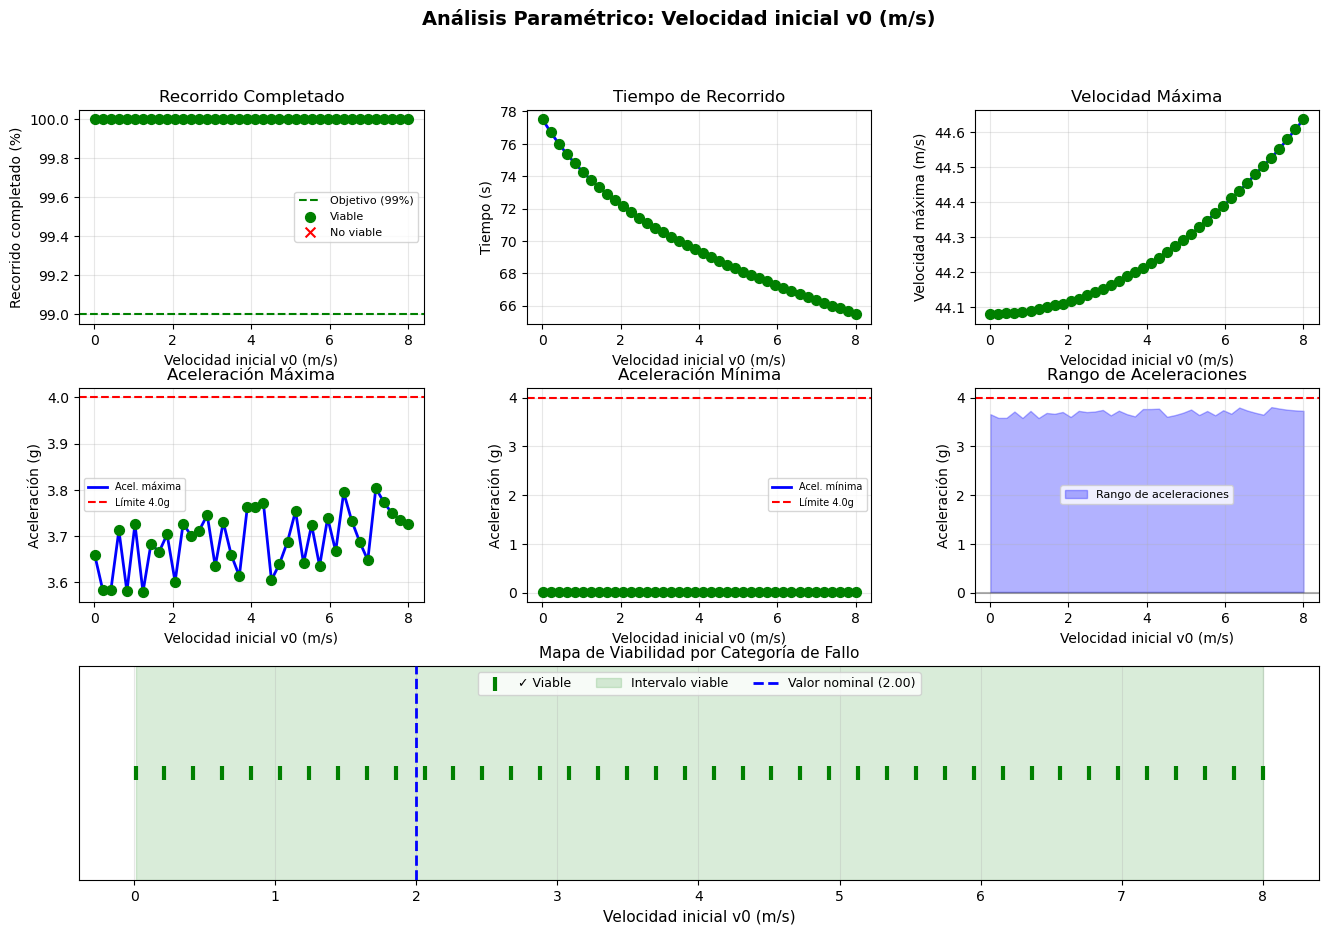


RESUMEN DE INTERVALOS VÁLIDOS
Parámetro            Valor Base      Intervalo Viable              
----------------------------------------------------------------------
Masa (kg)            800.00          [675.86, 1034.48]             
Coef. fricción μ     0.01            [0.00, 0.02]                  
Coef. arrastre ca    0.40            [0.35, 0.45]                  
Superficie Sf (m²)   2.00            [1.59, 2.36]                  
Velocidad v0 (m/s)   2.00            [0.01, 8.00]                  


In [5]:
class AnalizadorParametrico:
    """
    Realiza análisis variando un parámetro mientras mantiene los demás constantes.
    """
    
    ACELERACION_MAXIMA = 4.0
    
    def __init__(self, montaña_rusa, params_base):
        self.mr = montaña_rusa
        self.params_base = params_base
        self.bspline = montaña_rusa.bspline
        self.derivadas = mrusa.trayec_der(self.bspline)
        self.resultados = {}
    
    def simular_con_params(self, params):
        """Simula y retorna métricas de viabilidad."""
        try:
            sol = scin.solve_ivp(
                mrusa.edofun_mr,
                [0, 200],
                [0.0, params.v0],
                method='DOP853',
                args=[self.derivadas, params.mu, params.cv, params.grav],
                events=[mrusa.finalVia, mrusa.paradaVagon],
                dense_output=True,
                max_step=0.1
            )
            
            if not sol.success:
                return None
            
            u_final = sol.y[0][-1]
            v = sol.y[1]
            t = sol.t
            
            # Si después de 10s no ha avanzado >1% del recorrido, está parado
            if len(t) > 10:
                idx_10s = np.argmin(np.abs(t - 10))
                u_10s = u_final if idx_10s >= len(sol.y[0]) else sol.y[0][idx_10s]
                if u_10s < 0.01:
                    print(f"  Vagón estancado: u(10s)={u_10s:.3%}")
                    return {
                        'completa': False,
                        'u_final': u_10s,
                        't_final': 10.0,
                        'v_max': params.v0,
                        'v_min': 0.0,
                        'acel_max_g': 0.0,
                        'acel_min_g': 0.0,
                        'acel_excede_4g': False,
                        'viable': False,
                        'valor_param': None,
                        'sol': sol,
                        'estancado': True
                    }
            
            # Calcular aceleraciones
            u_eval = np.linspace(0, min(u_final, 1.0), 200)
            acel_total = []
            
            for u_i in u_eval:
                idx = np.argmin(np.abs(sol.y[0] - u_i))
                v_i = v[idx]
                try:
                    fN, base, ctes = mrusa.fuerzaNormal(u_i, v_i, self.derivadas, params.grav)
                    acel = mrusa.aceleracion(v_i, base, params.mu, params.cv, fN, ctes[1], params.grav)
                    acel_total.append(acel[0])
                except:
                    acel_total.append(0)
            
            acel_total = np.array(acel_total)
            acel_g = acel_total / params.grav
                        
            metricas = {
                'completa': u_final >= 0.99,
                'u_final': u_final,
                't_final': t[-1],
                'v_max': v.max(),
                'v_min': v.min(),
                'acel_max_g': acel_g.max(),
                'acel_min_g': acel_g.min(),
                'acel_excede_4g': abs(acel_g.max()) > self.ACELERACION_MAXIMA,
                'viable': u_final >= 0.99 and abs(acel_g.max()) <= self.ACELERACION_MAXIMA,
                'sol': sol,
                'estancado': False
            }
            
            return metricas
            
        except Exception as e:
            print(f"Error en simulación: {e}")
            return None
    
    def variar_parametro(self, nombre_param, valores):
        """
        Varía un parámetro manteniendo los demás constantes.
        Estrategia: Partir del valor nominal y explorar en ambas direcciones.
        
        Parámetros:
        -----------
        nombre_param : str - 'masa', 'mu', 'ca', 'Sf', 'v0'
        valores : array - valores a probar
        """
        print(f"\n{'='*70}")
        print(f"VARIANDO: {nombre_param}")
        print(f"{'='*70}")
        print(f"Valores base: m={self.params_base.masa}kg, "
              f"μ={self.params_base.mu}, ca={self.params_base.ca}, "
              f"Sf={self.params_base.Sf}m², v0={self.params_base.v0}m/s")
        print(f"Rango de análisis: {nombre_param} ∈ [{valores[0]:.2f}, {valores[-1]:.2f}]")
        print(f"{'-'*70}")
        
        # Obtener valor nominal
        if nombre_param == 'masa':
            val_nominal = self.params_base.masa
        elif nombre_param == 'mu':
            val_nominal = self.params_base.mu
        elif nombre_param == 'ca':
            val_nominal = self.params_base.ca
        elif nombre_param == 'Sf':
            val_nominal = self.params_base.Sf
        elif nombre_param == 'v0':
            val_nominal = self.params_base.v0
        else:
            raise ValueError(f"Parámetro '{nombre_param}' no reconocido")
        
        # Encontrar índice más cercano al valor nominal
        idx_nominal = np.argmin(np.abs(valores - val_nominal))
        val_nominal_real = valores[idx_nominal]
        
        print(f"Valor nominal: {val_nominal:.2f} → usando {val_nominal_real:.2f}")
        print(f"Estrategia: Nominal → Máximo, luego Nominal → Mínimo")
        print(f"{'-'*70}")
        
        resultados = []
        
        # =====================================================================
        # FASE 1: Desde nominal hacia ARRIBA (valores crecientes)
        # =====================================================================
        print("\nFASE 1: Explorando hacia valores CRECIENTES...")
        
        no_completa_consecutivos = 0
        for i in range(idx_nominal, len(valores)):
            val = valores[i]
            params = self._crear_params_modificados(nombre_param, val)
            metricas = self.simular_con_params(params)
            
            if metricas is not None:
                metricas['valor_param'] = val
                resultados.append(metricas)
                
                if not metricas['completa']:
                    no_completa_consecutivos += 1
                else:
                    no_completa_consecutivos = 0
                
                if (i == idx_nominal or 
                               (i - idx_nominal) % max(1, (len(valores) - idx_nominal)//5) == 0 or
                               no_completa_consecutivos == 1):
                    self._imprimir_resultado(nombre_param, val, metricas)
                
                # Parar si no completa 3 veces consecutivas (monotonicidad)
                if no_completa_consecutivos >= 3:
                    print(f"  Límite superior alcanzado en {nombre_param}={val:.2f}")
                    break
        
        # =====================================================================
        # FASE 2: Desde nominal hacia ABAJO (valores decrecientes)
        # =====================================================================
        print("\nFASE 2: Explorando hacia valores DECRECIENTES...")
        
        no_completa_consecutivos = 0
        # Empezar desde idx_nominal-1 (ya hicimos idx_nominal en fase 1)
        for i in range(idx_nominal - 1, -1, -1):
            val = valores[i]
            params = self._crear_params_modificados(nombre_param, val)
            metricas = self.simular_con_params(params)
            
            if metricas is not None:
                metricas['valor_param'] = val
                resultados.append(metricas)
                
                # OPTIMIZACIÓN ESPECIAL: Si se queda estancado, parar inmediatamente
                # (especialmente importante para v0 muy bajos)
                if metricas.get('estancado', False):
                    self._imprimir_resultado(nombre_param, val, metricas)
                    print(f"  Estancamiento detectado - límite inferior crítico en {nombre_param}={val:.2f}")
                    break
                
                if not metricas['completa']:
                    no_completa_consecutivos += 1
                else:
                    no_completa_consecutivos = 0
                
                if ((idx_nominal - i) % max(1, idx_nominal//5) == 0 or no_completa_consecutivos == 1):
                    self._imprimir_resultado(nombre_param, val, metricas)
                
                # Parar si no completa 3 veces consecutivas
                if no_completa_consecutivos >= 3:
                    print(f"  Límite inferior alcanzado en {nombre_param}={val:.2f}")
                    break
        
        # Ordenar resultados por valor del parámetro
        resultados.sort(key=lambda x: x['valor_param'])
        
        self.resultados[nombre_param] = resultados
        
        # Determinar intervalo viable
        viables = [r for r in resultados if r['viable']]
        if viables:
            vals_viables = [r['valor_param'] for r in viables]
            intervalo = (min(vals_viables), max(vals_viables))
            print(f"\n{'─'*70}")
            print(f"→ INTERVALO VIABLE: {nombre_param} ∈ [{intervalo[0]:.2f}, {intervalo[1]:.2f}]")
            print(f"  Valor nominal: {val_nominal:.2f}")
            print(f"  Margen inferior: {val_nominal - intervalo[0]:.2f} ({(val_nominal - intervalo[0])/val_nominal*100:.1f}%)")
            print(f"  Margen superior: {intervalo[1] - val_nominal:.2f} ({(intervalo[1] - val_nominal)/val_nominal*100:.1f}%)")
            print(f"  Configuraciones viables: {len(viables)}/{len(resultados)}")
        else:
            intervalo = None
            print(f"\n→ NO HAY VALORES VIABLES en el rango analizado")
        
        return resultados, intervalo
    
    def _crear_params_modificados(self, nombre_param, val):
        """Crea objeto ParametrosFisicos con un parámetro modificado."""
        params = ParametrosFisicos(
            masa=self.params_base.masa,
            v0=self.params_base.v0,
            mu=self.params_base.mu,
            ca=self.params_base.ca,
            Sf=self.params_base.Sf
        )
        
        if nombre_param == 'masa':
            params.masa = val
            params.cv = params.ca * params.Sf * params.rho_a / (2 * val)
        elif nombre_param == 'mu':
            params.mu = val
        elif nombre_param == 'ca':
            params.ca = val
            params.cv = val * params.Sf * params.rho_a / (2 * params.masa)
        elif nombre_param == 'Sf':
            params.Sf = val
            params.cv = params.ca * val * params.rho_a / (2 * params.masa)
        elif nombre_param == 'v0':
            params.v0 = val
        
        return params
    
    def _imprimir_resultado(self, nombre_param, val, metricas):
        """Imprime resultado de una simulación."""
        simbolo = '[OK] ' if metricas['viable'] else '[NO] '
        razon = ""
        
        if metricas.get('estancado', False):
            razon = " (ESTANCADO - no se mueve)"
        elif not metricas['completa']:
            razon = " (NO completa)"
        elif metricas['acel_excede_4g']:
            razon = " (>4g)"
        
        print(f"  {simbolo} {nombre_param}={val:6.2f}: "
              f"u={metricas['u_final']:5.1%}, "
              f"acel={metricas['acel_max_g']:4.1f}g{razon}")
    
    def visualizar_parametro(self, nombre_param, guardar=True):
        """Genera gráficos de análisis para un parámetro."""
        if nombre_param not in self.resultados:
            print(f"No hay resultados para {nombre_param}")
            return
        
        resultados = self.resultados[nombre_param]
        if not resultados:
            print(f"Lista de resultados vacía para {nombre_param}")
            return
        
        # Extraer datos
        vals = np.array([r['valor_param'] for r in resultados])
        u_final = np.array([r['u_final'] for r in resultados])
        t_final = np.array([r['t_final'] for r in resultados])
        v_max = np.array([r['v_max'] for r in resultados])
        acel_max_g = np.array([r['acel_max_g'] for r in resultados])
        acel_min_g = np.array([r['acel_min_g'] for r in resultados])
        viable = np.array([r['viable'] for r in resultados])
        
        # Crear figura
        fig = plt.figure(figsize=(16, 10))
        gs = GridSpec(3, 3, figure=fig, hspace=0.3, wspace=0.3)
        
        # Mapeo de nombres bonitos
        nombres = {
            'masa': 'Masa del vagón (kg)',
            'mu': 'Coeficiente de fricción μ',
            'ca': 'Coeficiente de arrastre ca',
            'Sf': 'Superficie frontal Sf (m²)',
            'v0': 'Velocidad inicial v0 (m/s)'
        }
        nombre_eje = nombres.get(nombre_param, nombre_param)
        
        # 1. Recorrido completado
        ax1 = fig.add_subplot(gs[0, 0])
        ax1.plot(vals, u_final * 100, 'b-', lw=2)
        ax1.axhline(99, color='g', ls='--', label='Objetivo (99%)')
        ax1.scatter(vals[viable], (u_final * 100)[viable], c='g', s=50, 
                   marker='o', label='Viable', zorder=5)
        ax1.scatter(vals[~viable], (u_final * 100)[~viable], c='r', s=50, 
                   marker='x', label='No viable', zorder=5)
        ax1.set_xlabel(nombre_eje)
        ax1.set_ylabel('Recorrido completado (%)')
        ax1.set_title('Recorrido Completado')
        ax1.legend(fontsize=8)
        ax1.grid(True, alpha=0.3)
        
        # 2. Tiempo de recorrido
        ax2 = fig.add_subplot(gs[0, 1])
        ax2.plot(vals, t_final, 'b-', lw=2)
        ax2.scatter(vals[viable], t_final[viable], c='g', s=50, marker='o', zorder=5)
        ax2.scatter(vals[~viable], t_final[~viable], c='r', s=50, marker='x', zorder=5)
        ax2.set_xlabel(nombre_eje)
        ax2.set_ylabel('Tiempo (s)')
        ax2.set_title('Tiempo de Recorrido')
        ax2.grid(True, alpha=0.3)
        
        # 3. Velocidad máxima
        ax3 = fig.add_subplot(gs[0, 2])
        ax3.plot(vals, v_max, 'b-', lw=2)
        ax3.scatter(vals[viable], v_max[viable], c='g', s=50, marker='o', zorder=5)
        ax3.scatter(vals[~viable], v_max[~viable], c='r', s=50, marker='x', zorder=5)
        ax3.set_xlabel(nombre_eje)
        ax3.set_ylabel('Velocidad máxima (m/s)')
        ax3.set_title('Velocidad Máxima')
        ax3.grid(True, alpha=0.3)
        
        # 4. Aceleración máxima
        ax4 = fig.add_subplot(gs[1, 0])
        ax4.plot(vals, acel_max_g, 'b-', lw=2, label='Acel. máxima')
        ax4.axhline(self.ACELERACION_MAXIMA, color='r', ls='--', label=f'Límite {self.ACELERACION_MAXIMA}g')
        ax4.scatter(vals[viable], acel_max_g[viable], c='g', s=50, marker='o', zorder=5)
        ax4.scatter(vals[~viable], acel_max_g[~viable], c='r', s=50, marker='x', zorder=5)
        ax4.set_xlabel(nombre_eje)
        ax4.set_ylabel('Aceleración (g)')
        ax4.set_title('Aceleración Máxima')
        ax4.legend(fontsize=7)
        ax4.grid(True, alpha=0.3)
        
        # 5. Aceleración mínima
        ax5 = fig.add_subplot(gs[1, 1])
        ax5.plot(vals, acel_min_g, 'b-', lw=2, label='Acel. mínima')
        ax5.axhline(self.ACELERACION_MAXIMA, color='r', ls='--', label=f'Límite {self.ACELERACION_MAXIMA}g')
        ax5.scatter(vals[viable], acel_min_g[viable], c='g', s=50, marker='o', zorder=5)
        ax5.scatter(vals[~viable], acel_min_g[~viable], c='r', s=50, marker='x', zorder=5)
        ax5.set_xlabel(nombre_eje)
        ax5.set_ylabel('Aceleración (g)')
        ax5.set_title('Aceleración Mínima')
        ax5.legend(fontsize=7)
        ax5.grid(True, alpha=0.3)
        
        # 6. Rango de aceleraciones
        ax6 = fig.add_subplot(gs[1, 2])
        ax6.fill_between(vals, acel_min_g, acel_max_g, alpha=0.3, color='blue', label='Rango de aceleraciones')
        ax6.axhline(self.ACELERACION_MAXIMA, color='r', ls='--')
        ax6.axhline(0, color='k', ls='-', alpha=0.3)
        ax6.set_xlabel(nombre_eje)
        ax6.set_ylabel('Aceleración (g)')
        ax6.set_title('Rango de Aceleraciones')
        ax6.legend(fontsize=8)
        ax6.grid(True, alpha=0.3)
        
        # 7. Mapa de viabilidad
        ax7 = fig.add_subplot(gs[2, :])
        
        # Separar por tipo de fallo
        viable_mask = viable
        estancado_mask = np.array([r.get('estancado', False) for r in resultados])
        no_completa_mask = np.array([not r['completa'] and not r.get('estancado', False) 
                                      for r in resultados])
        acel_alta_mask = np.array([r['completa'] and r['acel_excede_4g'] 
                                    for r in resultados])
        
        # Plotear por categorías
        if any(viable_mask):
            ax7.scatter(vals[viable_mask], np.ones(sum(viable_mask)), 
                       c='green', s=100, marker='|', linewidths=3, 
                       label='✓ Viable', zorder=5)
        
        if any(estancado_mask):
            ax7.scatter(vals[estancado_mask], np.ones(sum(estancado_mask)), 
                       c='orange', s=100, marker='|', linewidths=3, 
                       label='✗ Estancado', zorder=4)
        
        if any(no_completa_mask):
            ax7.scatter(vals[no_completa_mask], np.ones(sum(no_completa_mask)), 
                       c='red', s=100, marker='|', linewidths=3, 
                       label='✗ No completa', zorder=4)
        
        if any(acel_alta_mask):
            ax7.scatter(vals[acel_alta_mask], np.ones(sum(acel_alta_mask)), 
                       c='purple', s=100, marker='|', linewidths=3, 
                       label='✗ Acel >4g', zorder=4)
        
        # Marcar intervalo viable con transparencia
        if any(viable_mask):
            vals_viables = vals[viable_mask]
            ax7.axvspan(vals_viables.min(), vals_viables.max(), 
                       alpha=0.15, color='green', label='Intervalo viable', zorder=1)
        
        # Marcar valor base
        val_base = getattr(self.params_base, nombre_param if nombre_param != 'mu' else 'mu')
        ax7.axvline(val_base, color='blue', ls='--', lw=2, 
                   label=f'Valor nominal ({val_base:.2f})', zorder=3)
        
        ax7.set_xlabel(nombre_eje, fontsize=11)
        ax7.set_yticks([])
        ax7.set_title('Mapa de Viabilidad por Categoría de Fallo', fontsize=11)
        ax7.legend(fontsize=9, loc='upper center', ncol=6)
        ax7.set_ylim(0.5, 1.5)
        ax7.grid(True, axis='x', alpha=0.3)
        
        plt.suptitle(f'Análisis Paramétrico: {nombre_eje}', 
                    fontsize=14, fontweight='bold')
        
        if guardar:
            archivo = f'mr2d_paso4_{nombre_param}.png'
            plt.savefig(archivo, dpi=150, bbox_inches='tight')
            print(f"\nFigura guardada: {archivo}")
        
        plt.show()
        return fig
    
    def resumen_intervalos(self):
        """Genera tabla resumen con todos los intervalos."""
        print("\n" + "="*70)
        print("RESUMEN DE INTERVALOS VÁLIDOS")
        print("="*70)
        print(f"{'Parámetro':<20} {'Valor Base':<15} {'Intervalo Viable':<30}")
        print("-"*70)
        
        nombres = {
            'masa': ('Masa (kg)', self.params_base.masa),
            'mu': ('Coef. fricción μ', self.params_base.mu),
            'ca': ('Coef. arrastre ca', self.params_base.ca),
            'Sf': ('Superficie Sf (m²)', self.params_base.Sf),
            'v0': ('Velocidad v0 (m/s)', self.params_base.v0)
        }
        
        for param, resultados in self.resultados.items():
            if param in nombres:
                nombre, val_base = nombres[param]
                viables = [r for r in resultados if r['viable']]
                
                if viables:
                    vals = [r['valor_param'] for r in viables]
                    intervalo = f"[{min(vals):.2f}, {max(vals):.2f}]"
                else:
                    intervalo = "Sin valores viables"
                
                print(f"{nombre:<20} {val_base:<15.2f} {intervalo:<30}")
        
        print("="*70)

analizador = AnalizadorParametrico(mr, params)

# Masa del vagón (kg): variar ±50%
print("\n" + "─"*70)
analizador.variar_parametro('masa', np.linspace(400, 1200, 30))
analizador.visualizar_parametro('masa')
    
# Coeficiente de fricción μ: variar de 0 a 0.05
print("\n" + "─"*70)
analizador.variar_parametro('mu', np.linspace(0.001, 0.05, 30))
analizador.visualizar_parametro('mu')
    
# Coeficiente de arrastre ca: variar de 0.1 a 1.5
print("\n" + "─"*70)
analizador.variar_parametro('ca', np.linspace(0.05, 1.5, 30))
analizador.visualizar_parametro('ca')
    
# Superficie frontal Sf (m²): variar de 0.5 a 5.0
print("\n" + "─"*70)
analizador.variar_parametro('Sf', np.linspace(0.5, 5.0, 30))
analizador.visualizar_parametro('Sf')
    
# Velocidad inicial v0 (m/s): RANGO AMPLIADO para encontrar límite crítico
# NOTA: Con descenso de 100m, incluso v0≈0 puede completar (energía potencial)
# Buscamos el límite inferior donde se queda estancado al inicio
print("\n" + "─"*70)
print("NOTA: Velocidad inicial - verificando si se estanca al inicio")
print("      (Con descenso A=100m, la energía potencial domina sobre v0)")
analizador.variar_parametro('v0', np.linspace(0.01, 8.0, 40))
analizador.visualizar_parametro('v0')
    
# 4. Resumen de intervalos
analizador.resumen_intervalos()